# 1. Thư viện

In [5]:
import math
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from scipy.stats import norm
from pandas.errors import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

%matplotlib inline

# 2. Dữ liệu

## 2.1. Đọc file dữ liệu

`application_record.csv` là thông tin người nộp đơn

`credit_record.csv` là lịch sử tính dụng

In [6]:
cc_data_full_data = pd.read_csv('datasets/raw/application_record.csv')
credit_status = pd.read_csv('datasets/raw/credit_record.csv')

## 2.2. Tạo target variable

Hai tệp này được kết hợp và xử lý để tạo ra biến mục tiêu `Is_high_risk` (Có rủi ro cao không). Biến này xác định xem một khách hàng có từng quá hạn thanh toán trên 60 ngày hay không, là yếu tố cốt lõi để mô hình dự đoán.

In [7]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is_high_risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is_high_risk']=='Yes','Is_high_risk']=1
cc_data_full_data.loc[cc_data_full_data['Is_high_risk']=='No','Is_high_risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

/tmp/ipykernel_9002/1638824809.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
/tmp/ipykernel_9002/1638824809.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single ste

## 2.3. Đổi tên thuôc tính

Đổi tên các cột trong bộ dữ liệu để dễ đọc và dễ hiểu hơn

In [8]:
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender', # Giới tính
    'FLAG_OWN_CAR':'Has_a_Car', # Có xe hơi
    'FLAG_OWN_REALTY':'Has_a_Property', # Có bất động sản
    'CNT_CHILDREN':'Children_Count', # Số lượng con cái
    'AMT_INCOME_TOTAL':'Income', # Tổng thu nhập
    'NAME_INCOME_TYPE':'Employment_Status', # Tình trạng việc làm
    'NAME_EDUCATION_TYPE':'Education_Level', # Trình độ học vấn
    'NAME_FAMILY_STATUS':'Marital_Status', # Tình trạng hôn nhân
    'NAME_HOUSING_TYPE':'Dwelling', # Loại hình nhà ở
    'DAYS_BIRTH':'Age', # Tuổi
    'DAYS_EMPLOYED': 'Employment_Length', # Thời gian làm việc
    'FLAG_MOBIL': 'Has_a_Mobile_Phone', # Có điện thoại di động
    'FLAG_WORK_PHONE': 'Has_a_Work_Phone', # Có điện thoại bàn
    'FLAG_PHONE': 'Has_a_Phone', # Có điện thoại
    'FLAG_EMAIL': 'Has_an_Email', # Có email
    'OCCUPATION_TYPE': 'Job_Title', # Chức vụ
    'CNT_FAM_MEMBERS': 'Family_Member_Count', # Số lượng thành viên gia đình
    'Account age': 'Account_Age' # Tuổi tài khoản
    })

cc_data_full_data.to_csv('datasets/processed/full_data.csv', index=False)

# 2. Tổng quan và trực quan hóa dữ liệu

## 2.1. Tổng quan

Cung cấp một cái nhìn tổng quan về dữ liệu bằng các lệnh như `head()`, `info()`, `describe()`. Phần này cũng sử dụng biểu đồ ma trận để trực quan hóa các giá trị bị thiếu trong cột `Job_Title`.

In [164]:
cc_data_full_data.head()

,ID,Gender,Has_a_Car,Has_a_Property,Children_Count,Income,Employment_Status,Education_Level,Marital_Status,Dwelling,Age,Employment_Length,Has_a_Mobile_Phone,Has_a_Work_Phone,Has_a_Phone,Has_an_Email,Job_Title,Family_Member_Count,Account_Age,Is_high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [165]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has_a_Car            36457 non-null  object 
 3   Has_a_Property       36457 non-null  object 
 4   Children_Count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment_Status    36457 non-null  object 
 7   Education_Level      36457 non-null  object 
 8   Marital_Status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment_Length    36457 non-null  int64  
 12  Has_a_Mobile_Phone   36457 non-null  int64  
 13  Has_a_Work_Phone     36457 non-null  int64  
 14  Has_a_Phone          36457 non-null  int64  
 15  Has_an_Email         36457 non-null 

In [166]:
cc_data_full_data.describe()

,ID,Children_Count,Income,Age,Employment_Length,Has_a_Mobile_Phone,Has_a_Work_Phone,Has_a_Phone,Has_an_Email,Family_Member_Count,Account_Age
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


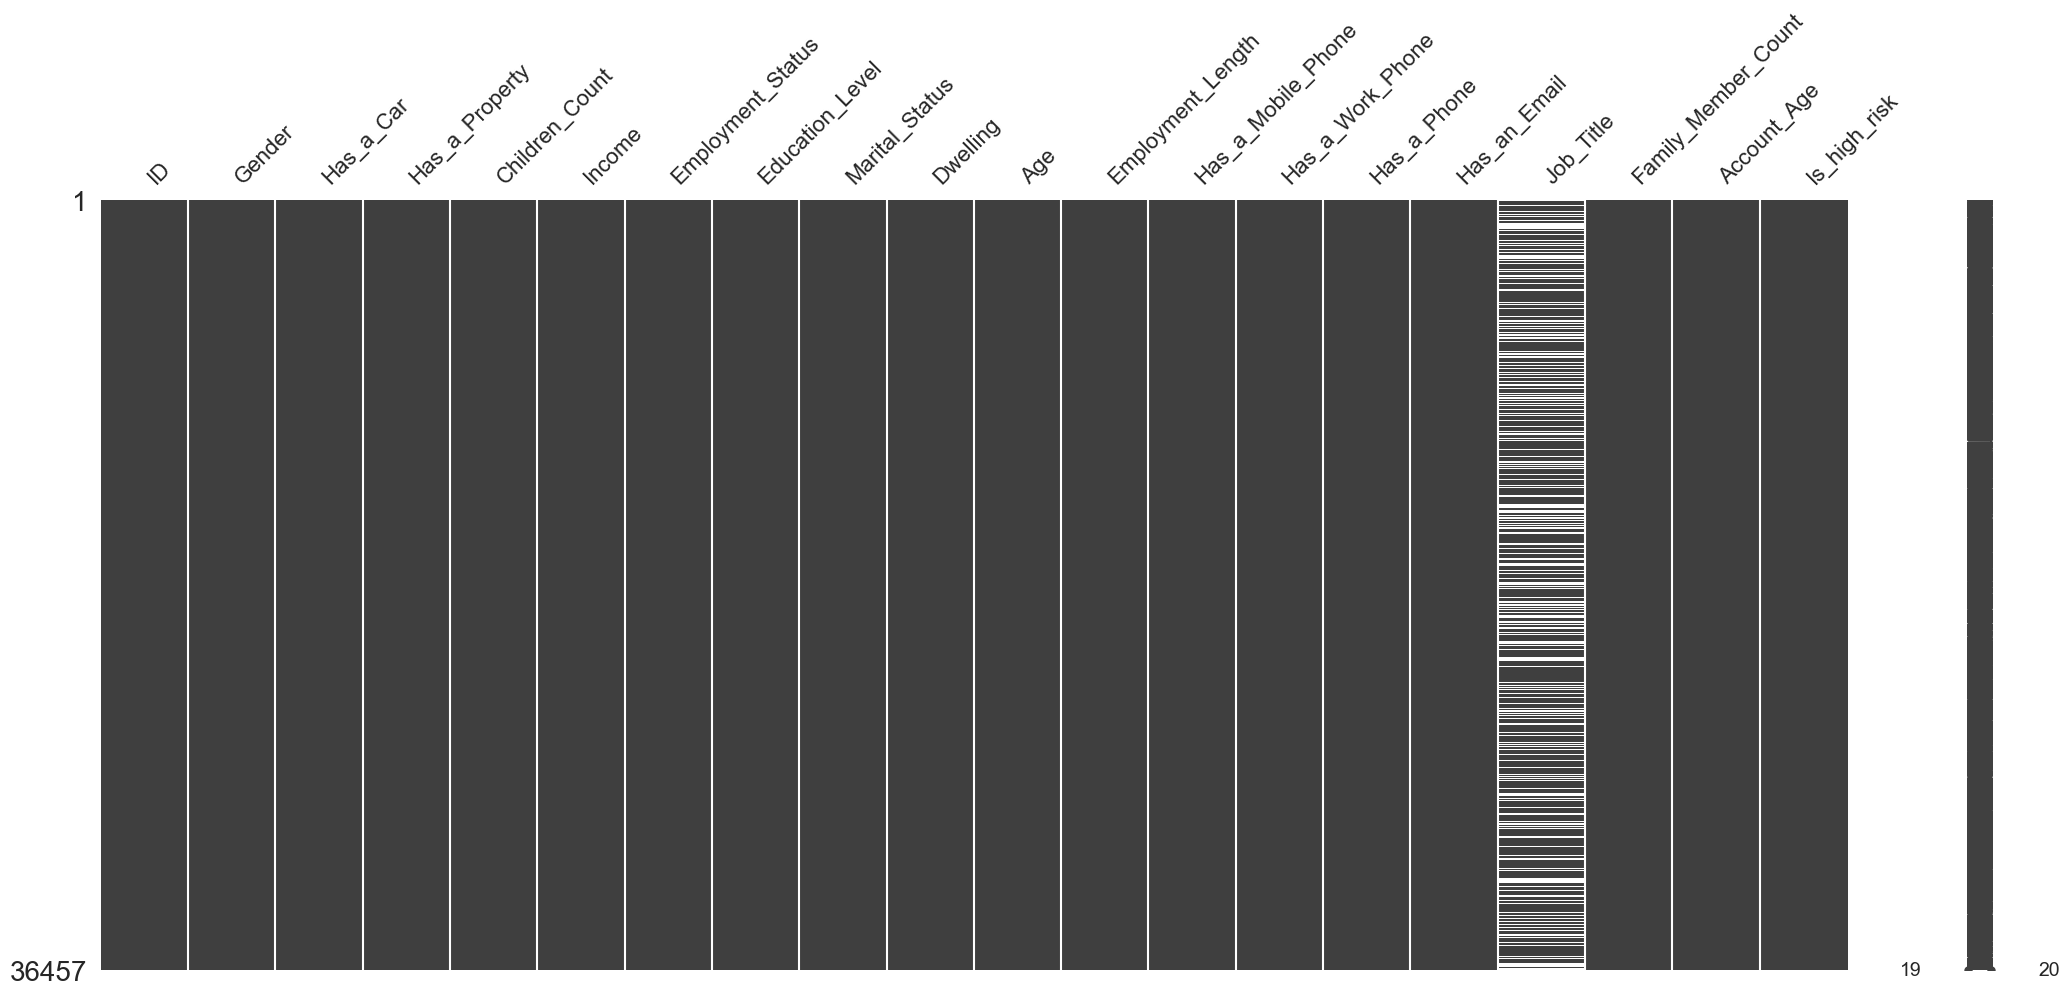

In [167]:
msno.matrix(cc_data_full_data)
plt.show()

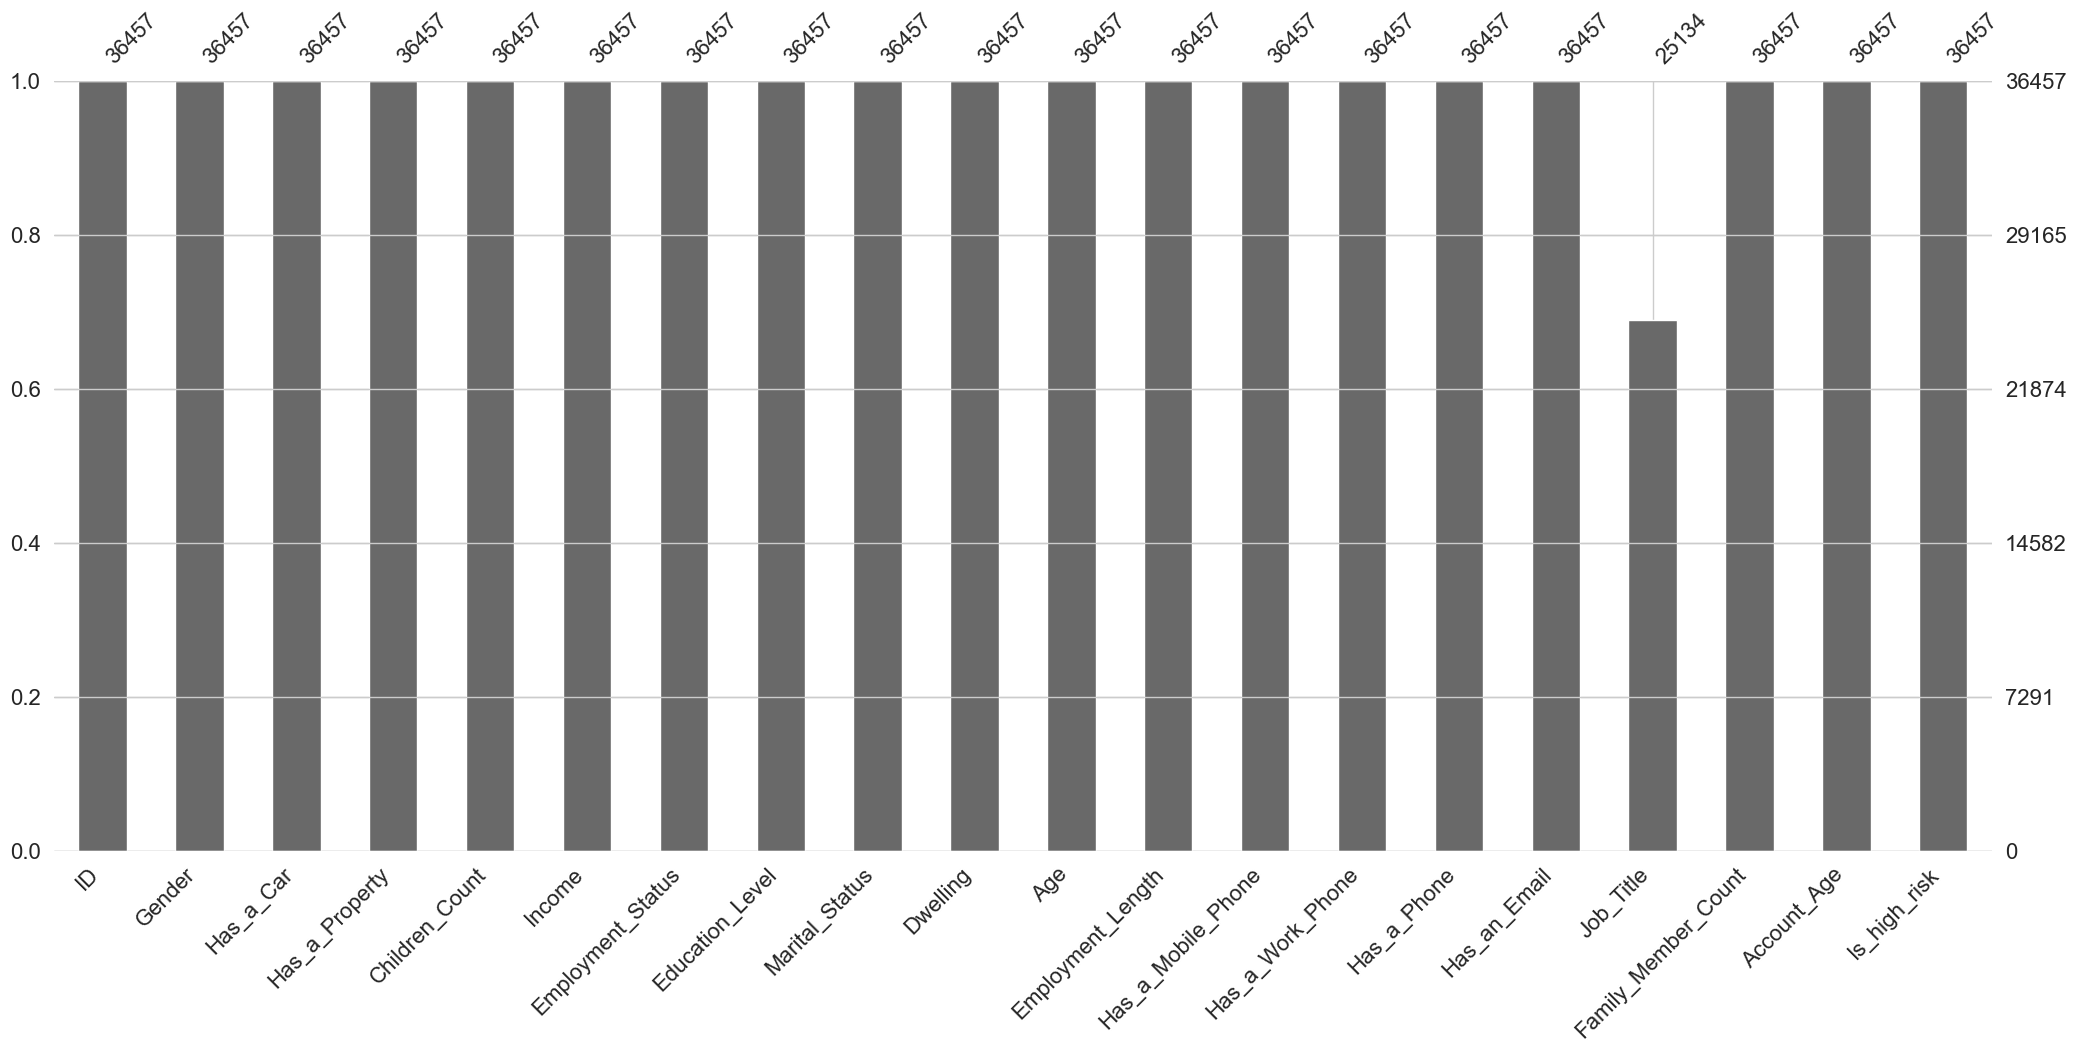

In [168]:
msno.bar(cc_data_full_data)
plt.show()

## 2.2. Trực quan hóa

### 2.2.1. Tiền xử lý dữ liệu

1. `Account age` (Tuổi tài khoản)

**Lý do chính**: Rò rỉ dữ liệu (Data Leakage).

**Giải thích**: Đây là lý do quan trọng nhất. Trong Phần 1.1 của notebook, cột MONTHS_BALANCE (là nguồn gốc của Account age) được sử dụng để tạo ra biến mục tiêu Is high risk. Cụ thể, logic là "nếu một khách hàng có bất kỳ tháng nào quá hạn (giá trị < -60) thì họ là 'rủi ro cao'".

Nếu giữ lại cột Account age để dự đoán Is high risk, mô hình sẽ "gian lận". Nó sẽ học được một quy tắc gần như tuyệt đối (ví dụ: "nếu Account age < -60 thì 100% là rủi ro cao"), dẫn đến điểm số chính xác ảo trên tập huấn luyện, nhưng sẽ hoàn toàn thất bại khi dự đoán dữ liệu thực tế (vì lúc đó bạn chưa biết lịch sử tài khoản của họ).

2. `Job title` (Chức danh công việc)

**Lý do chính**: Quá nhiều giá trị bị thiếu (Missing Values).

**Giải thích**: Khoảng 30.5% số hàng không có thông tin về chức danh.

Việc cố gắng điền (impute) một lượng lớn dữ liệu bị thiếu như vậy có thể tạo ra nhiều "nhiễu" (noise) hơn là tín hiệu hữu ích, làm giảm chất lượng của mô hình. Do đó, quyết định an toàn và phổ biến là loại bỏ nó.

3. `Has a mobile phone` (Có điện thoại di động)

**Lý do chính**: Giá trị không đổi (Constant Value) / Phương sai bằng 0.

**Giải thích**: 100% ứng viên trong tập dữ liệu đều có điện thoại di động (giá trị = 1).

Một đặc trưng mà tất cả mọi người đều có cùng một giá trị sẽ không cung cấp bất kỳ thông tin hữu ích nào cho mô hình. Mô hình không thể học được bất kỳ sự khác biệt nào từ một cột không có sự thay đổi (không có phương sai).

4. `Children count` (Số lượng con cái)

**Lý do chính**: Sức mạnh dự đoán thấp (Low Predictive Power).

**Giải thích**: Trong phân tích đa biến (ví dụ: Phần 2.4.3), khi so sánh cột Children count với biến mục tiêu Is high risk, không có sự khác biệt rõ rệt hoặc xu hướng (pattern) đáng kể nào về rủi ro tín dụng giữa các nhóm có số lượng con cái khác nhau.

Vì đặc trưng này dường như không giúp ích cho việc phân biệt giữa nhóm rủi ro cao và nhóm rủi ro thấp, nó đã bị loại bỏ để làm cho mô hình đơn giản hơn và tập trung vào các đặc trưng có ảnh hưởng rõ rệt hơn.

C:\Users\AN\AppData\Local\Temp\ipykernel_2428\1096735558.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='Correlation', y='Variable', palette='viridis')


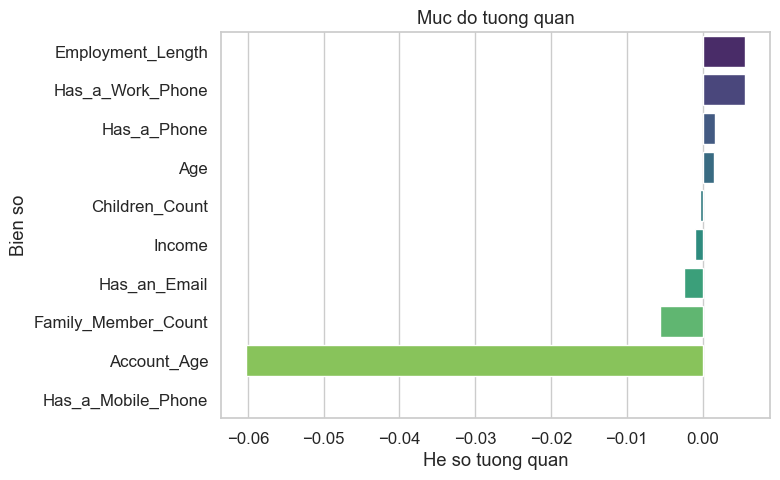

In [169]:
numeric_cols = [
    'Children_Count', 'Income', 'Age', 'Employment_Length',
    'Has_a_Mobile_Phone', 'Has_a_Work_Phone', 'Has_a_Phone',
    'Has_an_Email', 'Family_Member_Count', 'Account_Age'
]

# Chỉ lấy các biến số và biến mục tiêu
corr_df = cc_data_full_data[numeric_cols + ['Is_high_risk']].corr()['Is_high_risk'].drop('Is_high_risk').sort_values(ascending=False)

# Chuyển thành DataFrame để vẽ
corr_df = corr_df.reset_index()
corr_df.columns = ['Variable', 'Correlation']

plt.figure(figsize=(8,5))
sns.barplot(data=corr_df, x='Correlation', y='Variable', palette='viridis')
plt.title('Muc do tuong quan')
plt.xlabel('He so tuong quan')
plt.ylabel('Bien so')
plt.tight_layout()
plt.show()

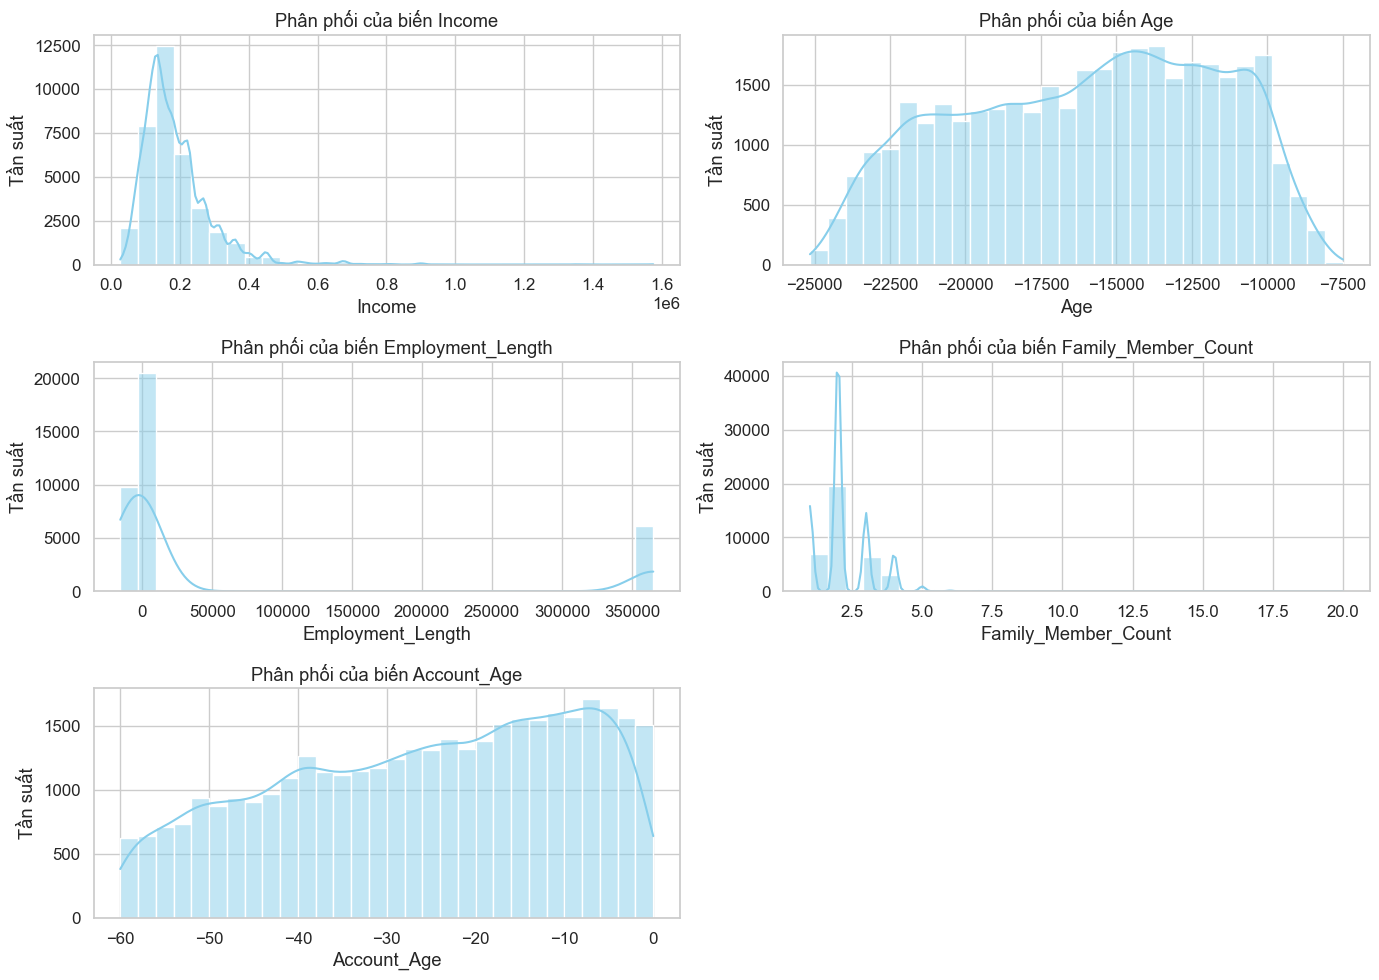

In [170]:
# Chọn các biến liên tục
continuous_vars = ['Income', 'Age', 'Employment_Length', 'Family_Member_Count', 'Account_Age'] 
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Vẽ các biểu đồ
plt.figure(figsize=(14, 10))

for i, var in enumerate(continuous_vars, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=cc_data_full_data, x=var, kde=True, color='skyblue', bins=30)
    plt.title(f'Phân phối của biến {var}')
    plt.xlabel(var)
    plt.ylabel('Tần suất')

plt.tight_layout()
plt.show()

In [171]:
# Drop những cột không cần thiết
columns_to_drop = ['ID', 'Account_Age', "Job_Title", "Has_a_Mobile_Phone", "Children_Count"]

data = cc_data_full_data.copy()
data.drop(columns=columns_to_drop, inplace=True)

#Employment_Length và Age là các giá trị âm, chuyển về dương
data[['Employment_Length','Age']] = np.abs(data[['Employment_Length','Age']])

#Employment_Length có giá trị 365243 (Nghỉ hưu), thay thế giá trị này bằng 0 của cột
data.loc[data['Employment_Length'] == 365243, 'Employment_Length'] = 0

#Age được tính bằng ngày, chuyển đổi sang năm
data['Age'] = (data['Age'] / 365.25)

In [172]:
#Chuyển các cột đặc trưng nhị phân từ 0,1 sang Yes, No nhằm dễ dàng cho One-Hot Encoding
feature_columns = ['Has_a_Work_Phone','Has_a_Phone','Has_an_Email']
for feature in feature_columns:
    data[feature] = data[feature].map({1: 'Yes', 0: 'No'})

In [173]:
# One-Hot Encoding cho các biến phân loại
feature_columns_for_one_hot_encoding = ['Gender', 'Marital_Status', 'Dwelling',
                                         'Employment_Status', 'Has_a_Car', 'Has_a_Property',
                                           'Has_a_Work_Phone', 'Has_a_Phone', 'Has_an_Email']

one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(data[feature_columns_for_one_hot_encoding])
# lấy tên các thuộc tính sau khi mã hóa
feature_names = one_hot_encoder.get_feature_names_out(feature_columns_for_one_hot_encoding)

# Mã hóa các biến phân loại
feature_encoded = one_hot_encoder.transform(data[feature_columns_for_one_hot_encoding]).toarray()
feature_encoded_df = pd.DataFrame(feature_encoded, columns=feature_names, index=data.index)

# Kết hợp với phần còn lại
rest_of_features = data.drop(columns=feature_columns_for_one_hot_encoding)
data = pd.concat([rest_of_features, feature_encoded_df], axis=1)

In [174]:
# Ordinal Encoder cho các thuộc tính có thứ bậc (Education_Level)
education_order = [
    'Lower secondary',
    'Secondary / secondary special',
    'Incomplete higher',
    'Higher education',
    'Academic degree'
]

ordinal_encoder = OrdinalEncoder(categories=[education_order])
data["Education_Level"] = ordinal_encoder.fit_transform(data[['Education_Level']])

In [175]:
# Min-Max Scaler cho các thuộc tính số liên tục [0, 1]
min_max_scaler_features = ['Age', 'Income', 'Employment_Length']

min_max_scaler = MinMaxScaler()
data[min_max_scaler_features] = min_max_scaler.fit_transform(data[min_max_scaler_features])

In [176]:
data["Is_high_risk"] = pd.to_numeric(data["Is_high_risk"])

In [177]:
data.head()

,Income,Education_Level,Age,Employment_Length,Family_Member_Count,Is_high_risk,Gender_F,Gender_M,Marital_Status_Civil marriage,Marital_Status_Married,...,Has_a_Car_N,Has_a_Car_Y,Has_a_Property_N,Has_a_Property_Y,Has_a_Work_Phone_No,Has_a_Work_Phone_Yes,Has_a_Phone_No,Has_a_Phone_Yes,Has_an_Email_No,Has_an_Email_Yes
0,0.258721,3.0,0.255676,0.28906,2.0,0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.258721,3.0,0.255676,0.28906,2.0,0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.055233,1.0,0.791768,0.07217,2.0,0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.156977,1.0,0.657929,0.19417,1.0,0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.156977,1.0,0.657929,0.19417,1.0,0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


### 2.2.2. Thống kê sơ bộ dữ liệu

In [178]:
print("Kích thước dữ liệu:",data.shape)
print(data.describe())

Kích thước dữ liệu: (36457, 34)
             Income  Education_Level           Age  Employment_Length  \
count  36457.000000     36457.000000  36457.000000       36457.000000   
mean       0.103156         1.572181      0.480449           0.140032   
std        0.065755         0.900959      0.237816           0.150627   
min        0.000000         0.000000      0.000000           0.000000   
25%        0.061047         1.000000      0.281549           0.025966   
50%        0.084302         1.000000      0.457114           0.098772   
75%        0.127907         3.000000      0.676499           0.200662   
max        1.000000         4.000000      1.000000           1.000000   

       Family_Member_Count  Is_high_risk      Gender_F      Gender_M  \
count         36457.000000  36457.000000  36457.000000  36457.000000   
mean              2.198453      0.016897      0.670105      0.329895   
std               0.911686      0.128886      0.470181      0.470181   
min               1.00

Tổng có 36457 mẫu dữ liệu

Giới tính: Nữ: 67.01% (24,434 người), Nam: 32.99% (12,023 người)

Tình trạng hôn nhân: Đã kết hôn: 68.71% (25,043 người), Kết hôn dân sự: 8.08% (2,945 người), Các trạng thái khác: 23.21% (8,469 người)

Quy mô gia đình: Trung bình 2.2 thành viên, Phổ biến nhất 2 thành viên (50% số hộ), Tối đa 20 thành viên

Trình độ học vấn: Trung bình 1.57/4 điểm, Phổ biến nhất mức 1 (trung học cơ sở), 75% số người dưới mức 3 (đại học)

Thu nhập: Phân bố tương đối đồng đều, Trung vị thấp hơn trung bình cho thập phân phối lệch phải

Sở hữu ô tô: Không có ô tô: 62.03% (22,614 người), Có ô tô: 37.97% (13,843 người)

Sở hữu tài sản: Không có tài sản: 32.78% (11,950 người), Có tài sản: 67.22% (24,507 người)

Điện thoại công việc: Không có: 77.45% (28,234 người), Có: 22.55% (8,223 người)

Điện thoại cá nhân: Không có: 70.52% (25,709 người), Có: 29.48% (10,748 người)

Email: Không có email: 91.03% (33,187 người), Có email: 8.97% (3,270 người)

Phân loại rủi ro tín dụng: Low Risk (An toàn): 98.31% (35,834 người), High Risk (Rủi ro cao): 1.69% (623 người)

### 2.2.3. PCA

In [179]:
# Drop Is_high_risk
X = data.drop('Is_high_risk', axis=1).values
y = data['Is_high_risk'].values
cov_matrix = np.cov(X.T)

# Tính gia trị riêng và vector riêng
eig_values, eig_vectors = np.linalg.eig(cov_matrix)
# Sắp xếp giá trị riêng giảm dần
idx = np.argsort(eig_values)[::-1]
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:, idx]
# Tính explained variance
explained_variance = (eig_values / np.sum(eig_values)) * 100
cumulative_variance = np.cumsum(explained_variance)

# Lấy phần thực
explained_variance_real = np.real(explained_variance)
cumulative_variance_real = np.real(cumulative_variance)
eig_vectors_real = np.real(eig_vectors)
n_components_opt = np.argmax(cumulative_variance_real >= 90) + 1
print('Số thành phần chính cần để giữ 90% phương sai:', n_components_opt)

Số thành phần chính cần để giữ 90% phương sai: 11


Chúng ta cần 11 thành phần chính để giải thích được 90% phương sai nên số chiều chúng ta sẽ chọn là 11

In [180]:
n_components_viz = 11
components_data = {}
for i in range(n_components_viz):
    components_data[f'PC{i+1}'] = X.dot(eig_vectors_real[:, i])

# Tạo DataFrame cho PCA
pca_df = pd.DataFrame(components_data)
pca_df['Is_high_risk'] = y
pca_df['Risk_Label'] = pca_df['Is_high_risk'].map({0: 'Low Risk', 1: 'High Risk'})

Vẽ biểu đồ trực quan các cặp thành phần chính

Ở đây là biểu đồ giữa 6 thành phần chính đầu tiên

   1. PC1 vs PC2
   2. PC1 vs PC3
   3. PC1 vs PC4
   4. PC1 vs PC5
   5. PC1 vs PC6
   6. PC2 vs PC3
   7. PC2 vs PC4
   8. PC2 vs PC5
   9. PC2 vs PC6
  10. PC3 vs PC4
  11. PC3 vs PC5
  12. PC3 vs PC6
  13. PC4 vs PC5
  14. PC4 vs PC6
  15. PC5 vs PC6


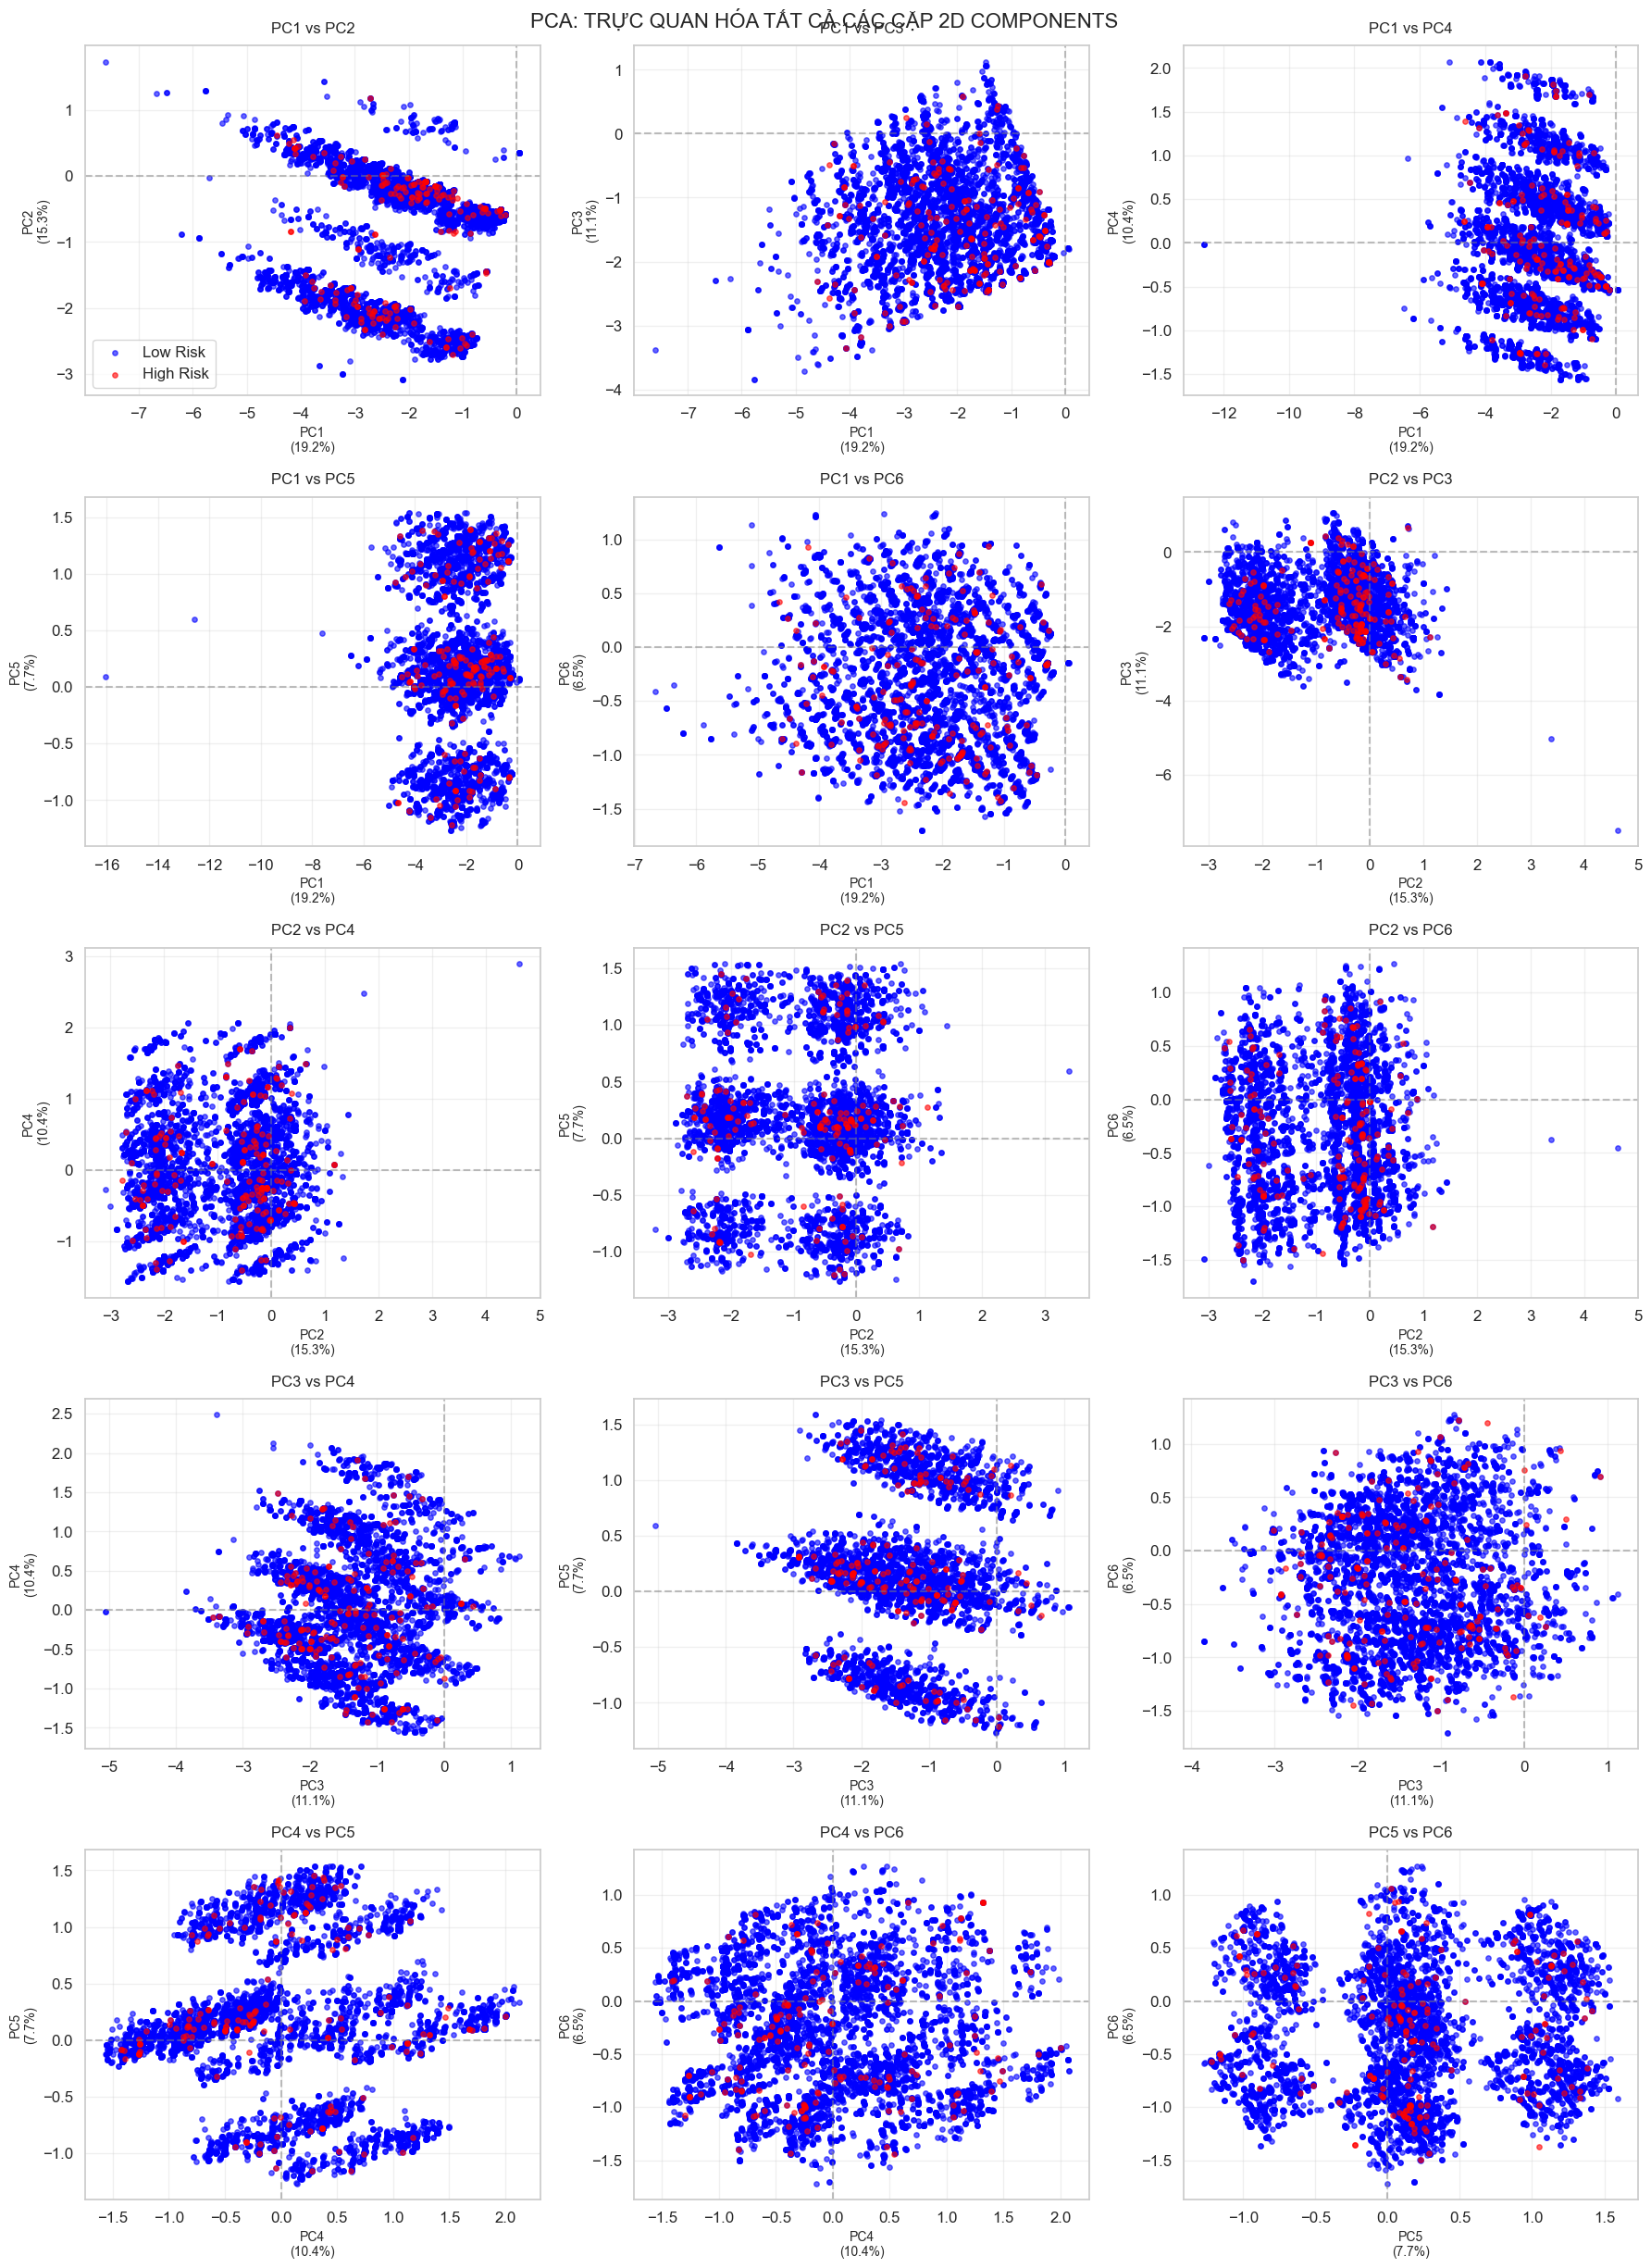

In [181]:
def plot_all_2d_pairs(pca_df, n_components=6):
    n_pairs = n_components * (n_components - 1) // 2
    n_cols = 3
    n_rows = (n_pairs + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    if n_rows > 1:
        axes = axes.flatten()
    elif n_cols == 1:
        axes = [axes]
    else:
        axes = axes
    pairs = []
    for i in range(n_components):
        for j in range(i+1, n_components):
            pairs.append((i, j))
    for idx, (i, j) in enumerate(pairs, 1):
        pc_i = f'PC{i+1}'
        pc_j = f'PC{j+1}'
        print(f"  {idx:2d}. {pc_i} vs {pc_j}")

    for idx, (i, j) in enumerate(pairs):
        ax = axes[idx]

        pc_i = f'PC{i+1}'
        pc_j = f'PC{j+1}'
        for risk_level, color, label in [(0, 'blue', 'Low Risk'), (1, 'red', 'High Risk')]:
            mask = (pca_df['Is_high_risk'] == risk_level)
            sample_mask = mask & (np.random.random(len(pca_df)) < 0.3)
            ax.scatter(pca_df.loc[sample_mask, pc_i], pca_df.loc[sample_mask, pc_j],
                      c=color, label=label, alpha=0.6, s=15)
        ax.set_xlabel(f'{pc_i}\n({explained_variance_real[i]:.1f}%)', fontsize=10)
        ax.set_ylabel(f'{pc_j}\n({explained_variance_real[j]:.1f}%)', fontsize=10)
        ax.set_title(f'{pc_i} vs {pc_j}', fontsize=12, pad=10)
        ax.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)

        if idx == 0:
            ax.legend()
    for idx in range(len(pairs), len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('PCA: TRỰC QUAN HÓA TẤT CẢ CÁC CẶP 2D COMPONENTS',
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
plot_all_2d_pairs(pca_df, n_components=6)

**Phương sai giải thích**

19.17928966885933
15.293850083117924
11.09808749661
10.410590898923495
7.666731579672867
6.529173642078226
5.323117123768698
4.702740972090921
3.9284114589050594
3.1721607961613705
2.770584522433118


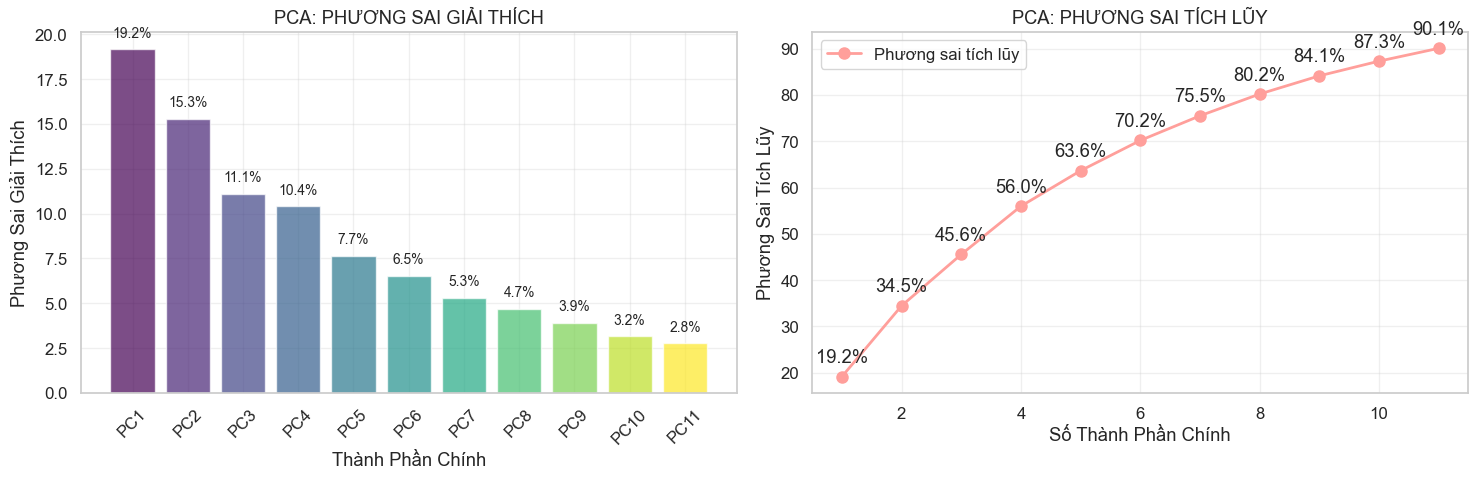

In [182]:
# Phương sai giải thích
for i in range(n_components_viz):
    print(explained_variance_real[i])
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
components = [f'PC{i+1}' for i in range(n_components_viz)]
variance_values = explained_variance_real[:n_components_viz]
colors = plt.cm.viridis(np.linspace(0, 1, n_components_viz))
bars = plt.bar(components, variance_values, color=colors, alpha=0.7)
plt.xlabel('Thành Phần Chính')
plt.ylabel('Phương Sai Giải Thích')
plt.title('PCA: PHƯƠNG SAI GIẢI THÍCH')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
for bar, variance in zip(bars, variance_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{variance:.1f}%', ha='center', va='bottom', fontsize=10)
plt.subplot(1, 2, 2)
plt.plot(range(1, n_components_viz+1), cumulative_variance_real[:n_components_viz],
         'ro-', linewidth=2, markersize=8, label='Phương sai tích lũy')
plt.xlabel('Số Thành Phần Chính')
plt.ylabel('Phương Sai Tích Lũy')
plt.title('PCA: PHƯƠNG SAI TÍCH LŨY')
plt.grid(True, alpha=0.3)
plt.legend()
for i, (x, y) in enumerate(zip(range(1, n_components_viz+1), cumulative_variance_real[:n_components_viz])):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()
#Như vậy với 11 thành phần chính sẽ giải thích được 90,1% phương sai

Trực quan hóa mối quan hệ của một số trường dữ liệu chính với đầu ra

PC1: 0.0045
PC2: -0.0049
PC3: 0.0155
PC4: 0.0071
PC5: 0.0155
PC6: 0.0068
PC7: -0.0151
PC8: 0.0085
PC9: -0.0006
PC10: -0.0141
PC11: 0.0107


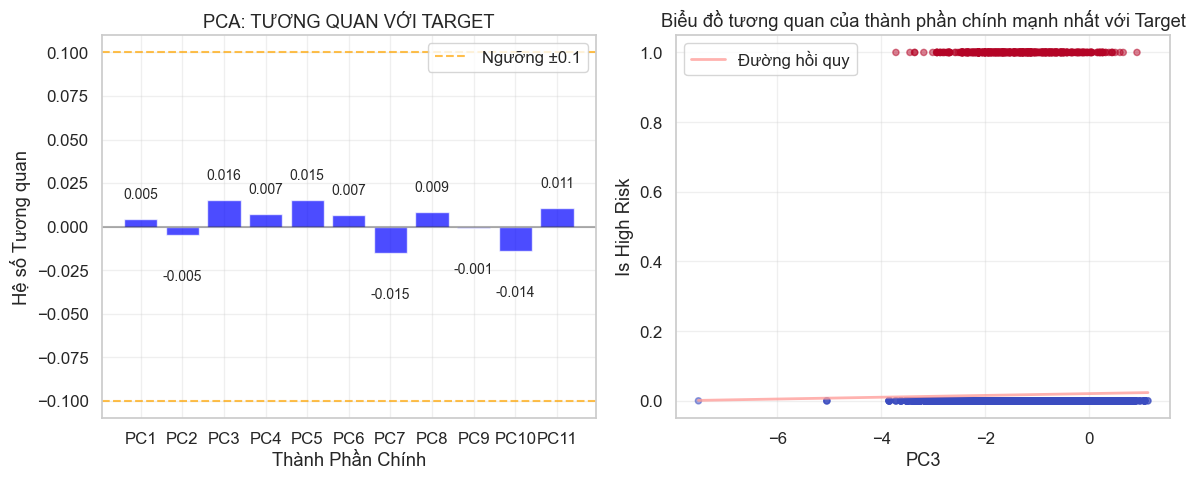

In [183]:
correlation_results = []
for i in range(n_components_viz):
    pc_col = f'PC{i+1}'
    corr = np.corrcoef(pca_df[pc_col], pca_df['Is_high_risk'])[0,1]
    correlation_results.append(corr)
    print( f'{pc_col}: {corr:.4f}')
best_pc_idx = np.argmax(np.abs(correlation_results))
best_pc_corr = correlation_results[best_pc_idx]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
colors = ['red' if abs(corr) > 0.1 else 'blue' for corr in correlation_results]
bars = plt.bar(components, correlation_results, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Ngưỡng ±0.1')
plt.axhline(y=-0.1, color='orange', linestyle='--', alpha=0.7)
plt.xlabel('Thành Phần Chính')
plt.ylabel('Hệ số Tương quan')
plt.title('PCA: TƯƠNG QUAN VỚI TARGET')
plt.legend()
plt.grid(True, alpha=0.3)
for bar, corr in zip(bars, correlation_results):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >=0 else -0.02),
             f'{corr:.3f}', ha='center', va='bottom' if height >=0 else 'top', fontsize=10)
plt.subplot(1, 2, 2)
best_pc = f'PC{best_pc_idx+1}'
scatter = plt.scatter(pca_df[best_pc], pca_df['Is_high_risk'],
                     c=pca_df['Is_high_risk'], cmap='coolwarm', alpha=0.5, s=20)
z = np.polyfit(pca_df[best_pc], pca_df['Is_high_risk'], 1)
p = np.poly1d(z)
x_sorted = np.sort(pca_df[best_pc])
plt.plot(x_sorted, p(x_sorted), "r-", linewidth=2, alpha=0.8, label='Đường hồi quy')

plt.xlabel(best_pc)
plt.ylabel('Is High Risk')
plt.title('Biểu đồ tương quan của thành phần chính mạnh nhất với Target')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
# Như vậy thành phần chính thứ 3 có tương quan manh nhất với target

### 2.2.4. LDA

In [184]:
class SimpleLDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.lda_components = None
        self.explained_variance_ratio = None
        self.scalings_ = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        classes = np.unique(y)
        n_classes = len(classes)
        if self.n_components is None:
            self.n_components = min(n_features, n_classes - 1)
        mean_overall = np.mean(X, axis=0)
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))
        class_means = {}
        class_counts = {}
        for c in classes:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            class_means[c] = mean_c
            class_counts[c] = X_c.shape[0]
            S_W += (X_c - mean_c).T.dot(X_c - mean_c)
            mean_diff = (mean_c - mean_overall).reshape(-1, 1)
            S_B += class_counts[c] * mean_diff.dot(mean_diff.T)

        try:
            S_W_inv = np.linalg.pinv(S_W)
            matrix = S_W_inv.dot(S_B)
            eigenvalues, eigenvectors = np.linalg.eig(matrix)
            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]
            self.lda_components = np.real(eigenvectors[:, :self.n_components])
            self.scalings_ = self.lda_components
            total_variance = np.sum(np.real(eigenvalues))
            self.explained_variance_ratio = np.real(eigenvalues[:self.n_components]) / total_variance
            self.classes_ = classes
            self.class_means_ = class_means
            self.means_ = mean_overall
        except np.linalg.LinAlgError as e:
            print(f"Lỗi trong tính toán LDA: {e}")
            self.lda_components = np.eye(n_features)[:, :self.n_components]
            self.explained_variance_ratio = np.ones(self.n_components) / self.n_components
    def transform(self, X):
        if self.lda_components is None:
            raise ValueError("Chưa fit model LDA")
        return X.dot(self.lda_components)

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
X = data.drop('Is_high_risk', axis=1).values
y = data['Is_high_risk'].values
lda = SimpleLDA(n_components=1)
X_lda = lda.fit_transform(X, y)
lda_df = pd.DataFrame({
    'LDA1': X_lda.flatten(),
    'Is_high_risk': y,
    'Risk_Label': ['Low Risk' if x == 0 else 'High Risk' for x in y]
})


## 2.3. Một số biểu đồ trực quan hóa

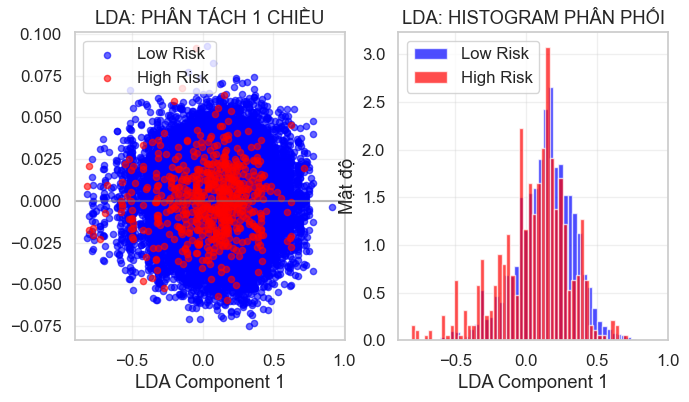

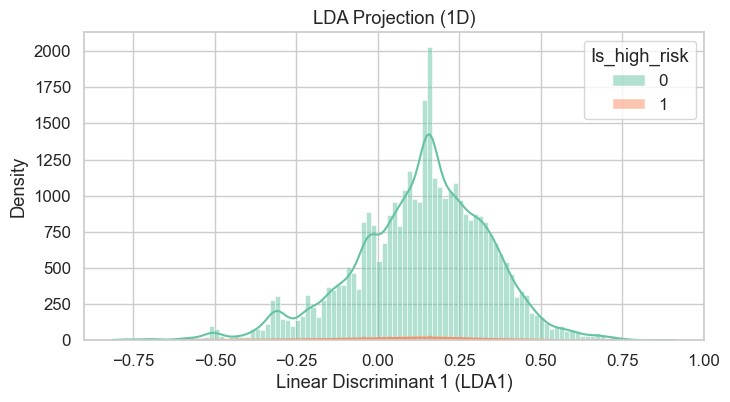

In [185]:
lda_low = lda_df[lda_df['Is_high_risk'] == 0]['LDA1']
lda_high = lda_df[lda_df['Is_high_risk'] == 1]['LDA1']

mean_low = lda_low.mean()
mean_high = lda_high.mean()
std_low = lda_low.std()
std_high = lda_high.std()
plt.figure(figsize=(16, 4))

# Biểu đồ 1: Scatter plot 1D
plt.subplot(1, 4, 1)
for risk_level, color, label in [(0, 'blue', 'Low Risk'), (1, 'red', 'High Risk')]:
    mask = lda_df['Is_high_risk'] == risk_level
    y_jitter = np.random.normal(0, 0.02, mask.sum())
    plt.scatter(lda_df.loc[mask, 'LDA1'], y_jitter,
               c=color, label=label, alpha=0.6, s=20)
plt.xlabel('LDA Component 1')
plt.title('LDA: PHÂN TÁCH 1 CHIỀU')
plt.axhline(y=0, color='grey', linestyle='-', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

# Biểu đồ 2: Histogram
plt.subplot(1, 4, 2)
plt.hist(lda_low, bins=50, alpha=0.7, color='blue', label='Low Risk', density=True)
plt.hist(lda_high, bins=50, alpha=0.7, color='red', label='High Risk', density=True)
plt.xlabel('LDA Component 1')
plt.ylabel('Mật độ')
plt.title('LDA: HISTOGRAM PHÂN PHỐI')
plt.legend()
plt.grid(True, alpha=0.3)


#
plt.figure(figsize=(8, 4))
sns.histplot(data=lda_df, x='LDA1', hue='Is_high_risk', kde=True, palette='Set2')
plt.title('LDA Projection (1D)')
plt.xlabel('Linear Discriminant 1 (LDA1)')
plt.ylabel('Density')
plt.show()

Biểu đồ 1 giúp phát hiện điểm ngoại lai (outliers)

Biểu đồ 2 giúp đánh giá xu hướng tổng thể và đặt ngưỡng Hai phân phối (0 và 1) gần như trùng lên nhau, tức là LDA1 chưa phân tách rõ ràng được hai nhóm.

Nói cách khác, đường biên phân tách tuyến tính mà LDA tìm ra chưa đủ mạnh để tách high risk và low risk, có thể do:

Các đặc trưng đầu vào không có mối quan hệ tuyến tính rõ ràng với nhãn.

Số lượng mẫu của nhóm 1 quá ít, khiến thuật toán khó học được phương sai và trung bình chính xác cho lớp này

**Dùng thư viện để kiểm tra lại kết quả đã làm ở trên**

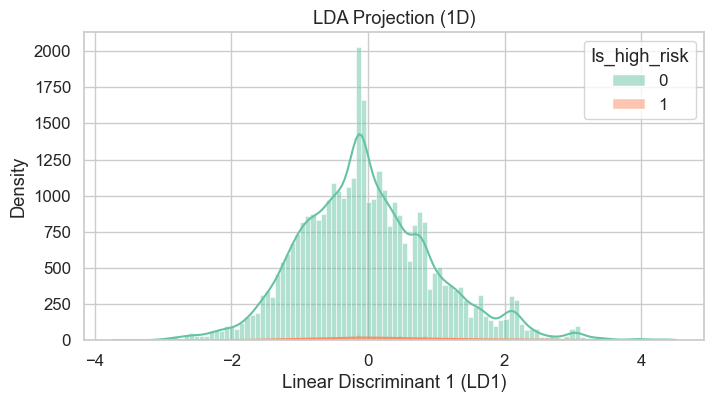

In [186]:
# Sử dụng thư viện sklearn để kiểm tra lại kết quả
lda = LinearDiscriminantAnalysis(n_components=1)

# Fit and transform the processed data using the target variable
X_lda = lda.fit_transform(X, y)

# Create a DataFrame for LDA results for easier plotting
lda_df = pd.DataFrame({
    'LDA1': X_lda.flatten(),
    'Is_high_risk': y,
    'Risk_Label': ['Low Risk' if x == 0 else 'High Risk' for x in y]
})

# Visualize the LDA-transformed data (1D scatter plot or histogram)
plt.figure(figsize=(8, 4))
sns.histplot(data=lda_df, x='LDA1', hue='Is_high_risk', kde=True, palette='Set2')
plt.title('LDA Projection (1D)')
plt.xlabel('Linear Discriminant 1 (LD1)')
plt.ylabel('Density')
plt.show()

# 3. Xây dựng mô hình

## 3.1. SMOTE không áp dụng cho cả tập dữ liệu rồi chia train / test

In [187]:
def SMOTE_oversample(df):
    oversample = SMOTE(sampling_strategy='minority')
    X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is_high_risk'],df['Is_high_risk'])
    final_df = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
    return final_df

In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Income                                  36457 non-null  float64
 1   Education_Level                         36457 non-null  float64
 2   Age                                     36457 non-null  float64
 3   Employment_Length                       36457 non-null  float64
 4   Family_Member_Count                     36457 non-null  float64
 5   Is_high_risk                            36457 non-null  int64  
 6   Gender_F                                36457 non-null  float64
 7   Gender_M                                36457 non-null  float64
 8   Marital_Status_Civil marriage           36457 non-null  float64
 9   Marital_Status_Married                  36457 non-null  float64
 10  Marital_Status_Separated                36457 non-null  fl

## 3.2. Chia tập dữ liệu và các hàm cần thiết

In [189]:
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df = SMOTE_oversample(train_df)
    test_df = SMOTE_oversample(test_df)

    X_train = train_df.drop('Is_high_risk', axis=1)
    y_train = train_df['Is_high_risk']
    X_test = test_df.drop('Is_high_risk', axis=1)
    y_test = test_df['Is_high_risk']
    return X_train.reset_index(drop=True), y_train.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

In [190]:
def print_confusion_matrix(name_model, y_pred, y_test, radio):
    fig, ax = plt.subplots(figsize=(8,8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues',values_format='d')
    plt.grid(False)

    # Title
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.title(f'Confusion Matrix {name_model}', fontsize=14)

    plt.savefig(f'image/Confusion_Matrix_{name_model}_{radio}.png')
    #show the plot
    plt.show()

In [191]:
# hàm để in đường cong ROC cho nhiều mô hình phân loại nhị phân
def plot_roc_curves_binary(models_list, y_test, y_pred):
    plt.figure(figsize=(10, 8))
     
    # Vẽ đường chéo (mô hình đoán ngẫu nhiên)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', alpha=0.7)

    for model_info in models_list:
        name = model_info['name']
        radio = model_info['radio']
                  
        # Tính FPR, TPR và AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred)
         
         # Vẽ đường cong ROC
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves {name}')
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.savefig(f'image/ROC_Curves_{name}_{radio}.png')
    plt.show()

## 3.3. Xây dựng mô hình

### 3.3.1. Xây dựng class KNN

In [192]:
class MyKNNClassifier:
  def __init__(self, n_neighbors=5):
    self.n_neighbors = n_neighbors
    self.X_train = None
    self.y_train = None

  def fit(self, X_train, y_train):
    self.X_train = np.array(X_train)
    self.y_train = np.array(y_train)

  def euclidean_distance(self, x1, x2):
    return np.linalg.norm(x1 - x2, axis = 1)

  def find_nearest_index(self, train, x, k):
    array_distance = self.euclidean_distance(train, x)
    return np.argsort(array_distance)[:k]

  def predict(self, X_test):
    # Chuẩn X_test về dạng numpy array
    X_test = np.array(X_test)

    y_pred_arr = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
      nearest_index = self.find_nearest_index(self.X_train, X_test[i], self.n_neighbors)
      k_nearest_labels = self.y_train[nearest_index]

      # Nếu nhãn 1 nhiều hơn hoặc bằng nhãn 0 trong k láng giềng gần nhất, dự đoán nhãn là 1
      if np.mean(k_nearest_labels) >= 0.5:
        y_pred_arr[i] = 1
      else:
        y_pred_arr[i] = 0
    return y_pred_arr

### 3.3.4. Xây dựng class Logistic Regression

In [193]:
class MyLogisticRegression:
    def __init__(self, eta=0.01, tol=1e-4, max_iter=1000):
        self.eta = eta        # learning rate
        self.tol = tol            # ngưỡng hội tụ
        self.max_iter = max_iter  # số vòng lặp tối đa
        self.w_ = None            # trọng số sau khi fit

    def _add_intercept(self, X):
        """Thêm cột bias (1) vào đầu X"""
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Huấn luyện mô hình bằng Batch Gradient Descent
        """
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)

        # Thêm cột bias
        X = self._add_intercept(X)
        N, d = X.shape

        # Khởi tạo trọng số = 0 (theo slide)
        self.w_ = np.zeros((d, 1))

        for iter in range(self.max_iter):
            w_old = self.w_.copy()

            # Tính h(x) cho toàn bộ dữ liệu
            h = self._sigmoid(X @ self.w_)

            # Cập nhật từng trọng số theta_j (j từ 0 đến d-1)
            for j in range(d):
                grad_j = np.sum((h - y) * X[:, j].reshape(-1, 1)) / N
                self.w_[j] = self.w_[j] - self.eta * grad_j

            # Kiểm tra hội tụ
            if np.linalg.norm(self.w_ - w_old) < self.tol:
                return self
        return self

    def predict_proba(self, X):
        """
        Dự đoán xác suất thuộc lớp 1
        """
        X = np.array(X)
        X = self._add_intercept(X)
        return self._sigmoid(X @ self.w_).flatten()

    def predict(self, X, threshold=0.5):
        """
        Dự đoán nhãn (0 hoặc 1), mặc định ngưỡng 0.5
        """
        prob = self.predict_proba(X)
        return (prob >= threshold).astype(int)

# 4. Huấn luyện mô hình

## 4.1. Huấn luyện mô hình với tập train/test tỉ lệ 4/1

In [194]:
X_train, y_train, X_test, y_test = data_split(data, test_size=0.2)

### 4.1.2. Logistic Regression

Logistic Regression Custom Model:
              precision    recall  f1-score   support

           0       0.55      0.58      0.56      7175
           1       0.55      0.52      0.53      7175

    accuracy                           0.55     14350
   macro avg       0.55      0.55      0.55     14350
weighted avg       0.55      0.55      0.55     14350



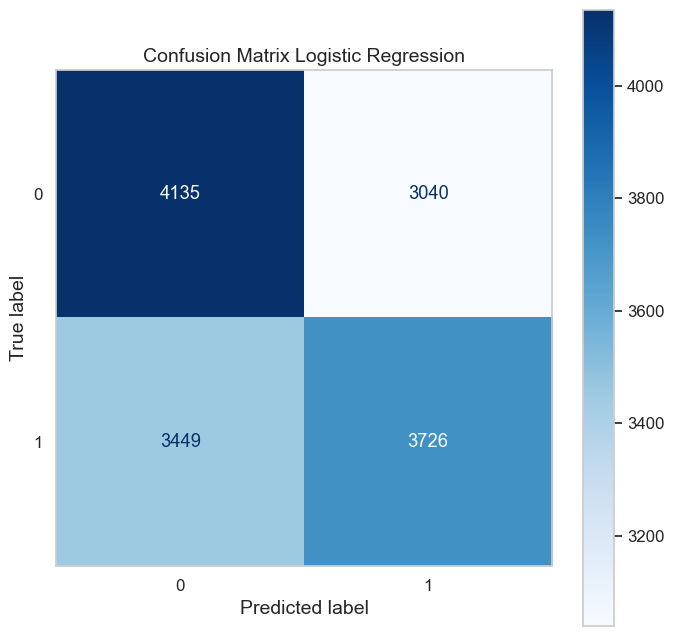

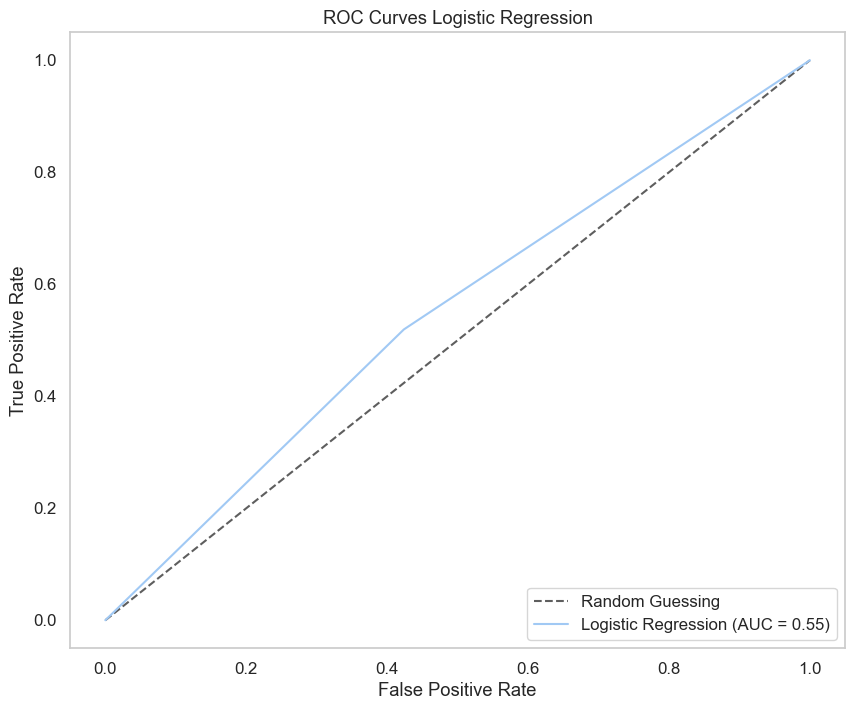

In [195]:
model_logreg = MyLogisticRegression(eta=0.01, tol=1e-4, max_iter=10000)
model_logreg.fit(X_train, y_train)

y_pred_logreg = model_logreg.predict(X_test)
print("Logistic Regression Custom Model:")
print(classification_report(y_test, y_pred_logreg))
print_confusion_matrix("Logistic Regression", y_pred_logreg, y_test, "4_1")

#vẽ ROC
plot_roc_curves_binary([{'name': 'Logistic Regression', 'radio': "4_1"}], y_test, y_pred_logreg)


### 4.1.4. KNN Classifier

              precision    recall  f1-score   support

           0       0.68      0.95      0.79      7175
           1       0.92      0.55      0.69      7175

    accuracy                           0.75     14350
   macro avg       0.80      0.75      0.74     14350
weighted avg       0.80      0.75      0.74     14350



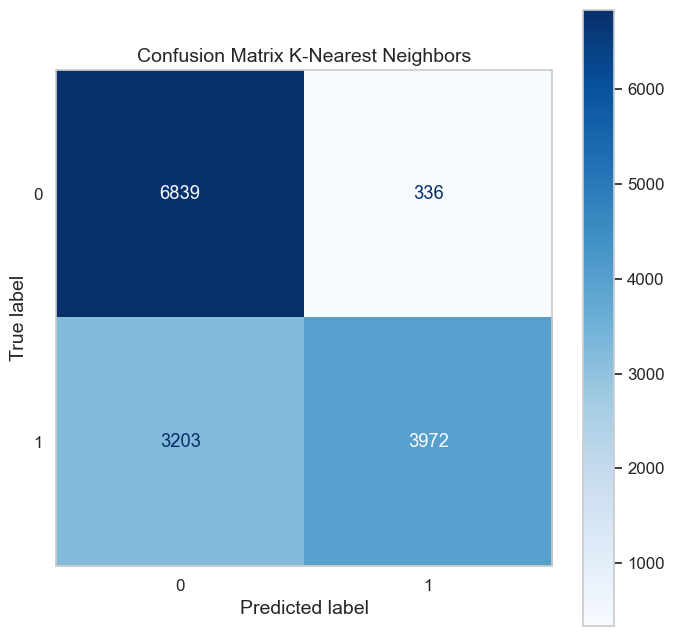

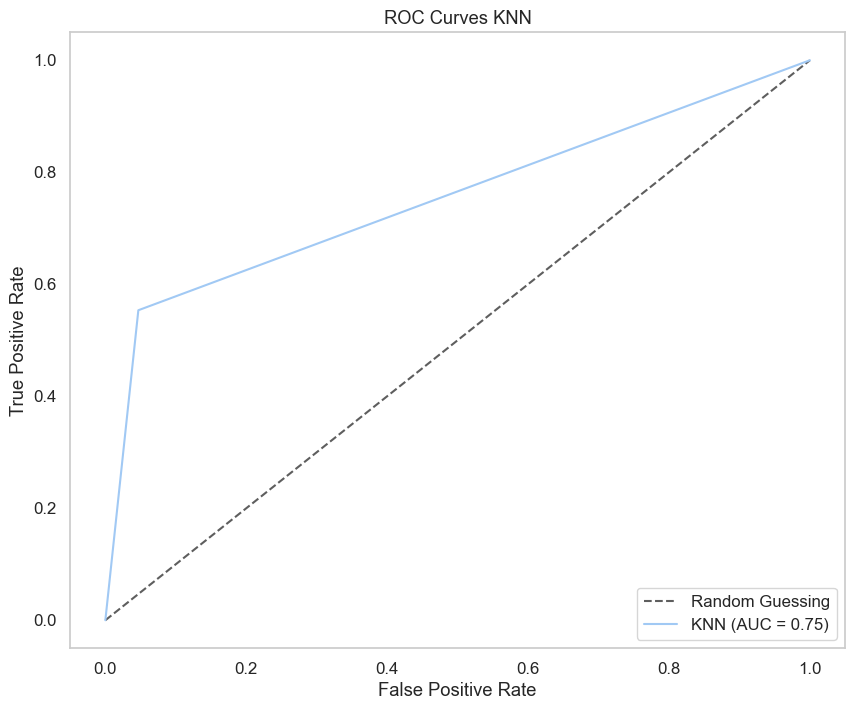

In [196]:
model_knn = MyKNNClassifier(n_neighbors=7)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
print_confusion_matrix("K-Nearest Neighbors", y_pred_knn, y_test, "4_1")
#ve ROC
plot_roc_curves_binary([{'name': 'KNN', 'radio': "4_1"}], y_test, y_pred_knn)

## 4.2. Huấn luyện mô hình với tập train/test tỉ lệ 7/3

In [197]:
X_train, y_train, X_test, y_test = data_split(data, test_size=0.3)

### 4.2.1. KNN Classifier

              precision    recall  f1-score   support

           0       0.66      0.95      0.78     10759
           1       0.91      0.51      0.66     10759

    accuracy                           0.73     21518
   macro avg       0.79      0.73      0.72     21518
weighted avg       0.79      0.73      0.72     21518



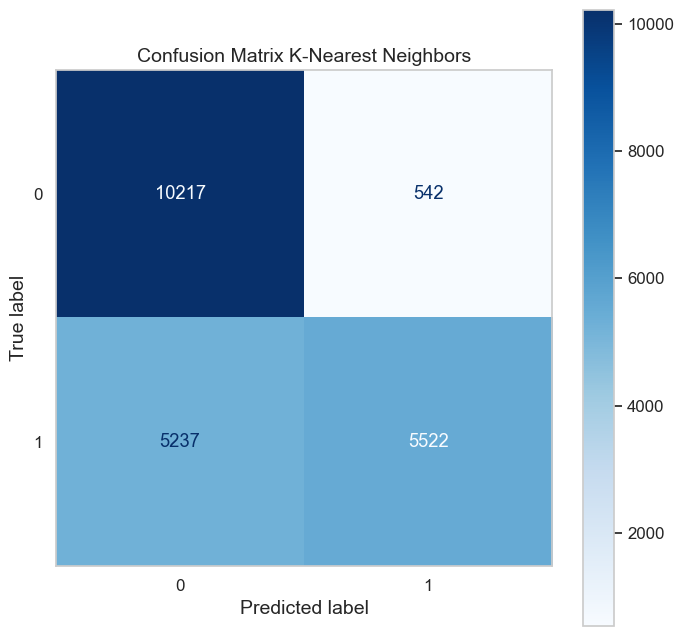

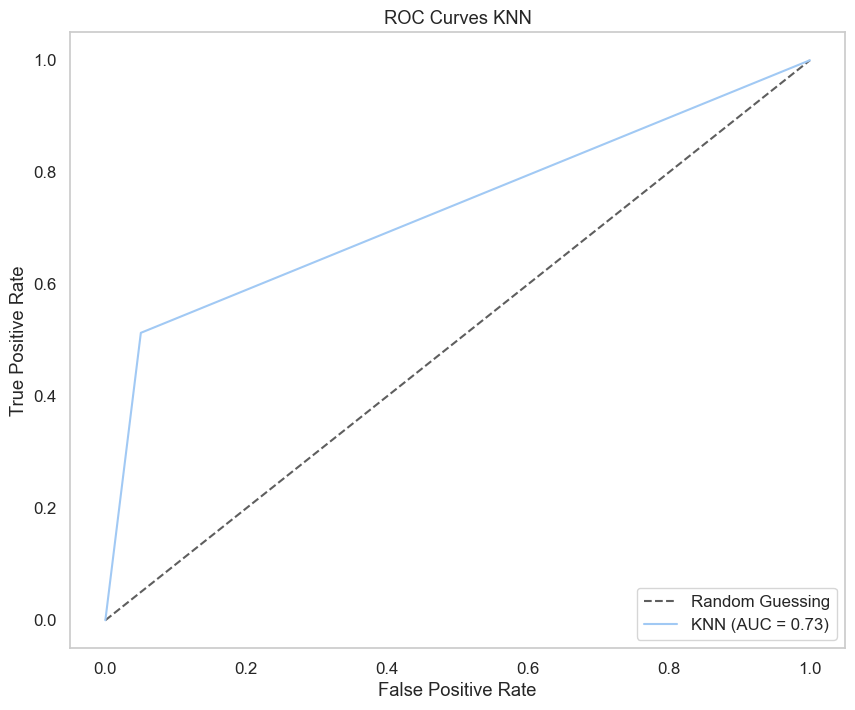

In [198]:
model_knn = MyKNNClassifier(n_neighbors=7)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
print_confusion_matrix("K-Nearest Neighbors", y_pred_knn, y_test, "7_3")
#ve ROC
plot_roc_curves_binary([{'name': 'KNN', 'radio': "7_3"}], y_test, y_pred_knn)

### 4.2.4. Logistic Regression

Logistic Regression Custom Model:
              precision    recall  f1-score   support

           0       0.53      0.58      0.55     10759
           1       0.54      0.49      0.51     10759

    accuracy                           0.54     21518
   macro avg       0.54      0.54      0.53     21518
weighted avg       0.54      0.54      0.53     21518



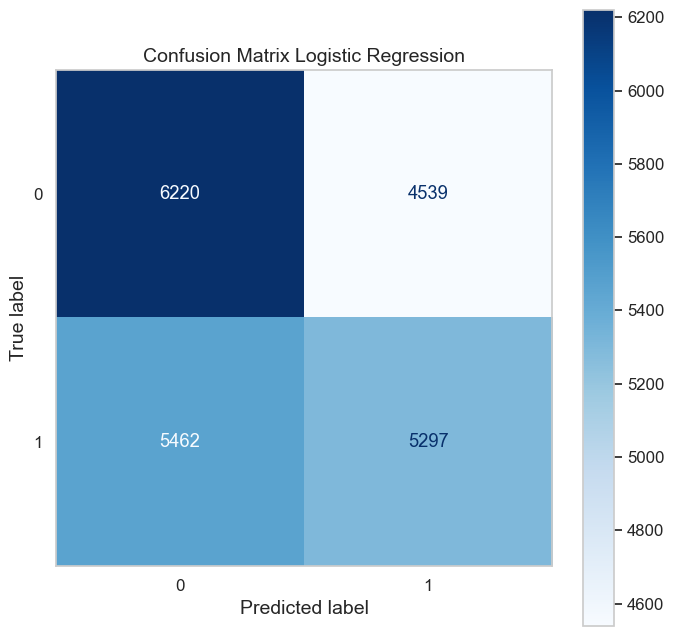

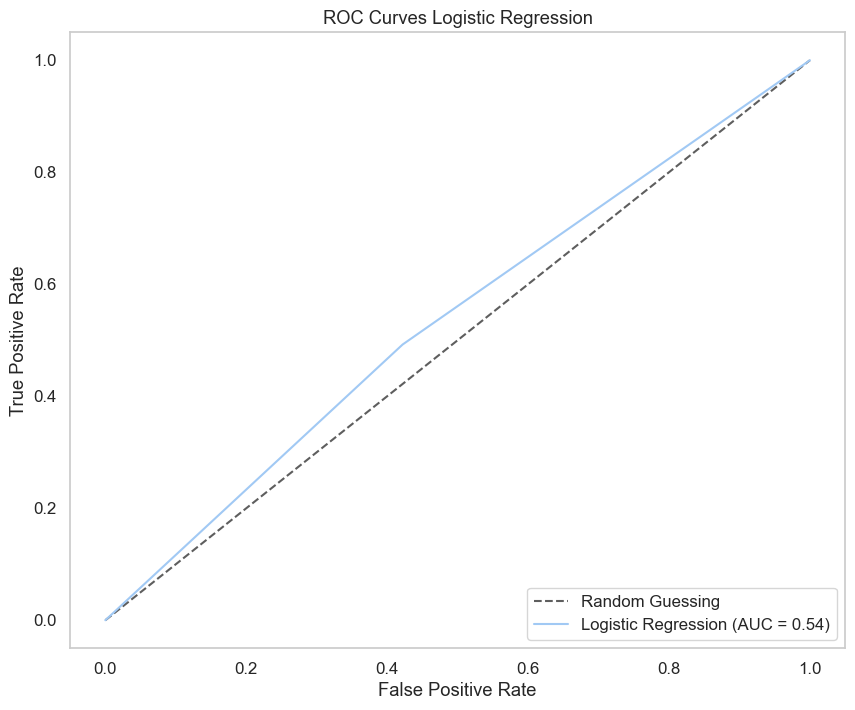

In [199]:
model_logreg = MyLogisticRegression(eta=0.01, tol=1e-4, max_iter=10000)
model_logreg.fit(X_train, y_train)

y_pred_logreg = model_logreg.predict(X_test)
print("Logistic Regression Custom Model:")
print(classification_report(y_test, y_pred_logreg))
print_confusion_matrix("Logistic Regression", y_pred_logreg, y_test, "7_3")

#vẽ ROC
plot_roc_curves_binary([{'name': 'Logistic Regression', 'radio': "7_3"}], y_test, y_pred_logreg)

## 4.3. Huấn luyện mô hình với tập train/test tỉ lệ 6/4

In [200]:
X_train, y_train, X_test, y_test = data_split(data, test_size=0.4)

### 4.3.1. KNN Classifier

              precision    recall  f1-score   support

           0       0.64      0.95      0.76     14344
           1       0.90      0.47      0.61     14344

    accuracy                           0.71     28688
   macro avg       0.77      0.71      0.69     28688
weighted avg       0.77      0.71      0.69     28688



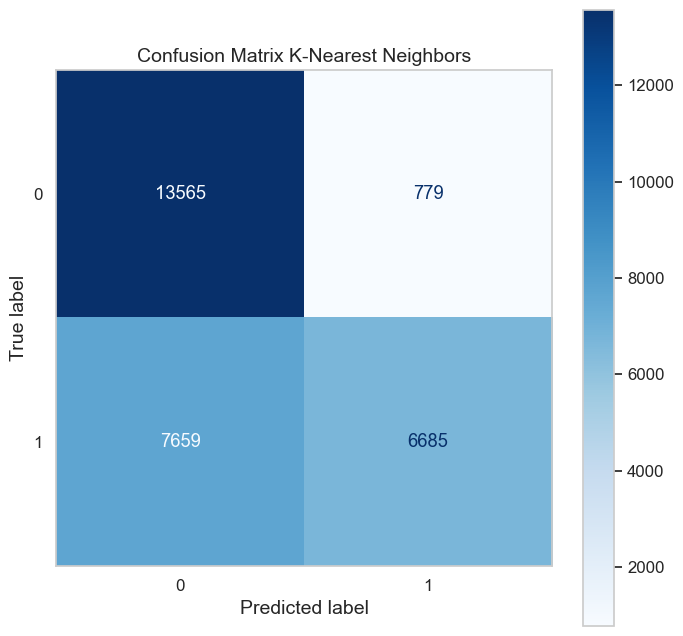

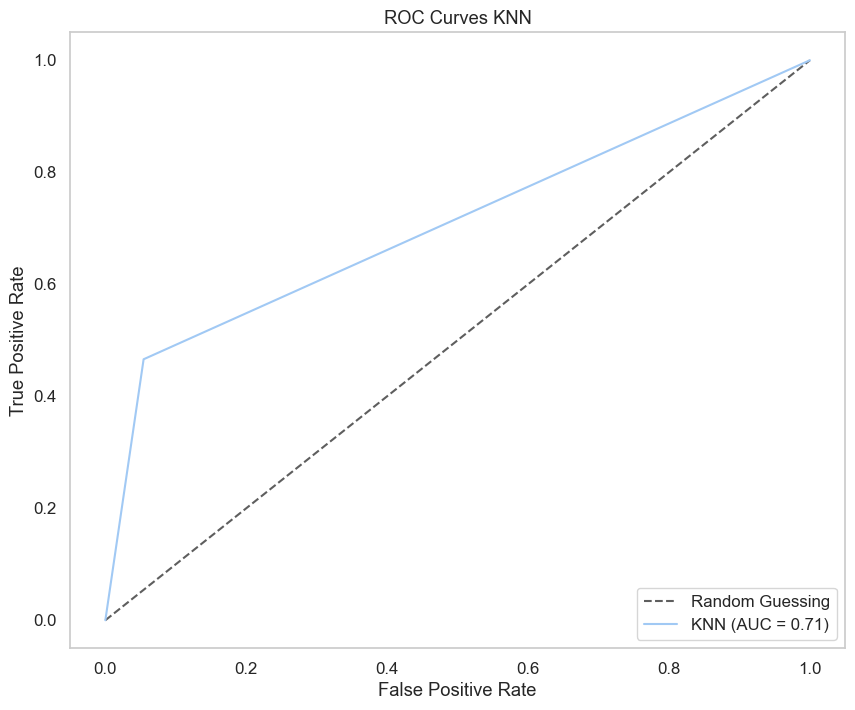

In [201]:
model_knn = MyKNNClassifier(n_neighbors=7)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
print_confusion_matrix("K-Nearest Neighbors", y_pred_knn, y_test, "6_4")
#ve ROC
plot_roc_curves_binary([{'name': 'KNN', 'radio': "6_4"}], y_test, y_pred_knn)

### 4.3.2. Logistic Regression

Logistic Regression Custom Model:
              precision    recall  f1-score   support

           0       0.51      0.59      0.55     14344
           1       0.52      0.43      0.47     14344

    accuracy                           0.51     28688
   macro avg       0.51      0.51      0.51     28688
weighted avg       0.51      0.51      0.51     28688



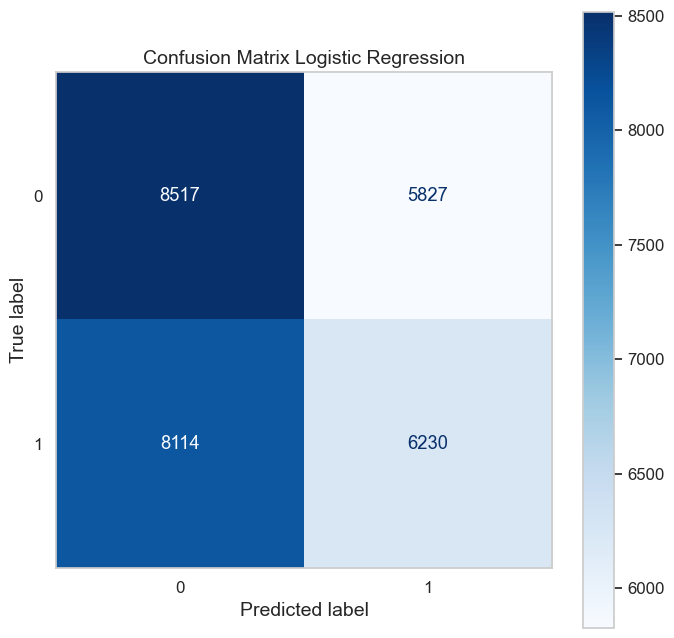

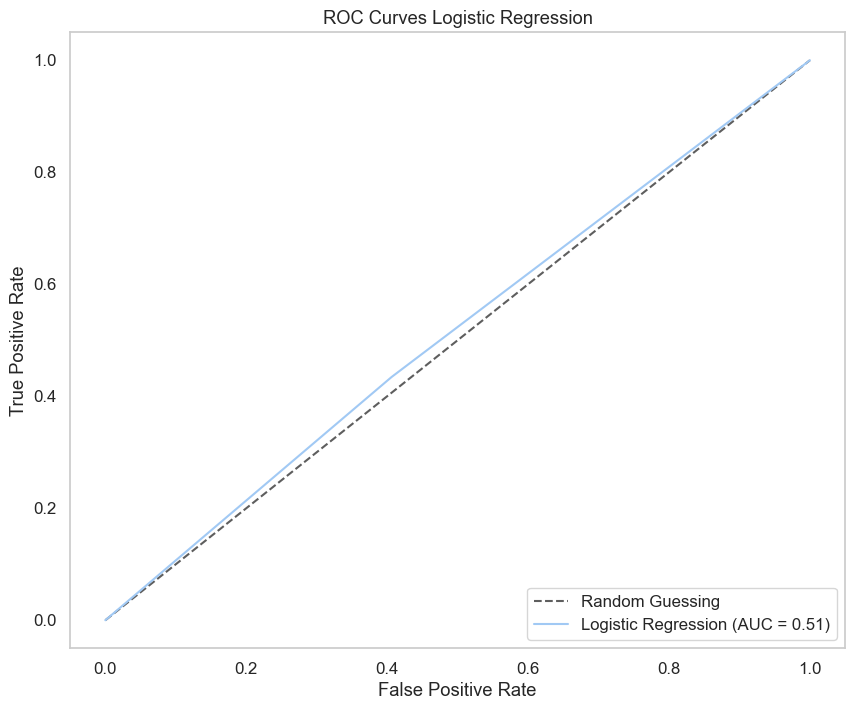

In [202]:
model_logreg = MyLogisticRegression(eta=0.01, tol=1e-4, max_iter=10000)
model_logreg.fit(X_train, y_train)

y_pred_logreg = model_logreg.predict(X_test)
print("Logistic Regression Custom Model:")
print(classification_report(y_test, y_pred_logreg))
print_confusion_matrix("Logistic Regression", y_pred_logreg, y_test, "6_4")

#vẽ ROC
plot_roc_curves_binary([{'name': 'Logistic Regression', 'radio': "6_4"}], y_test, y_pred_logreg)

## 4.4. Huấn luyện mô hình với tập dữ liệu giảm chiều bằng PCA

In [203]:
X_train, y_train, X_test, y_test = data_split(data, test_size=0.2)

In [204]:
pca = PCA(n_components= 11)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### 4.4.1. KNN Classifier

              precision    recall  f1-score   support

           0       0.66      0.96      0.78      7175
           1       0.92      0.51      0.66      7175

    accuracy                           0.73     14350
   macro avg       0.79      0.73      0.72     14350
weighted avg       0.79      0.73      0.72     14350



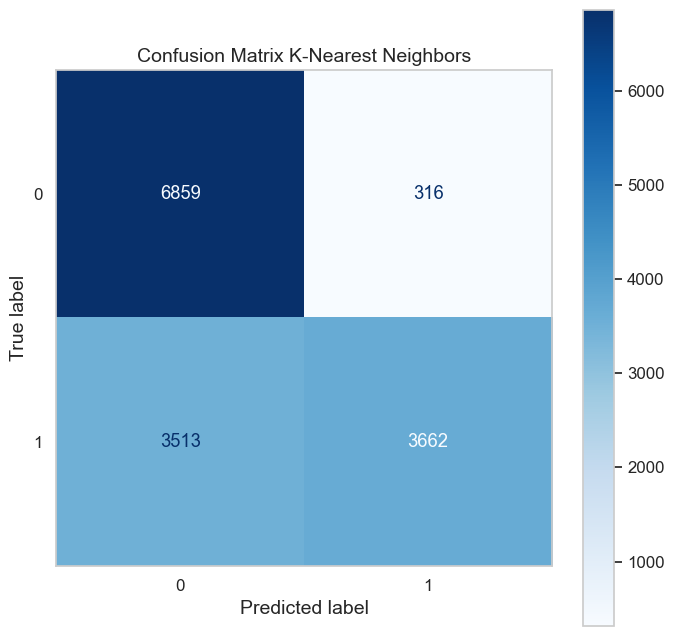

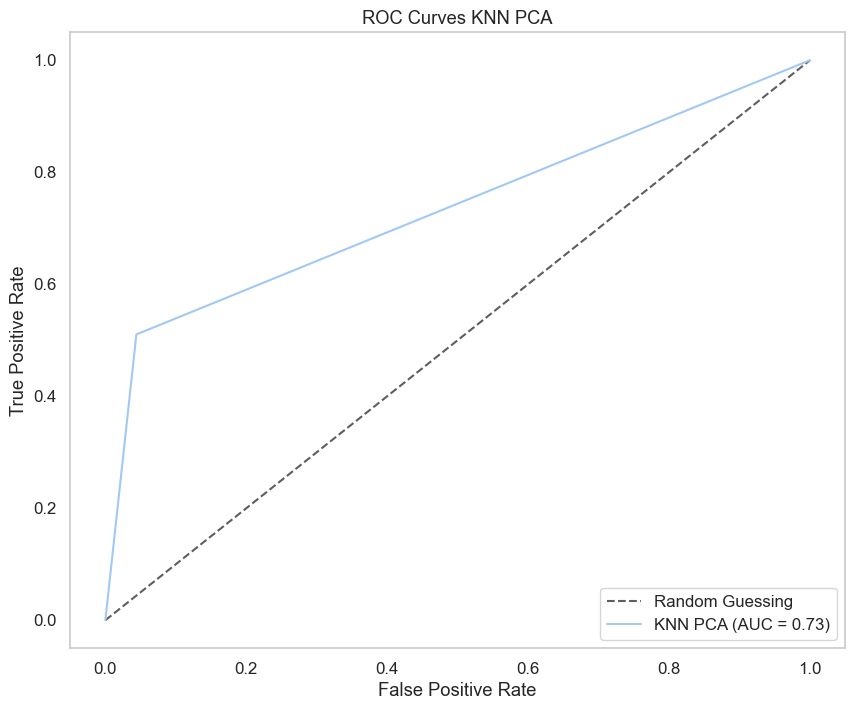

In [205]:
model_knn = MyKNNClassifier(n_neighbors=7)
model_knn.fit(X_train_pca, y_train)

y_pred_knn = model_knn.predict(X_test_pca)

print(classification_report(y_test, y_pred_knn))
print_confusion_matrix("K-Nearest Neighbors", y_pred_knn, y_test, "PCA")
#ve ROC
plot_roc_curves_binary([{'name': 'KNN PCA', 'radio': "PCA"}], y_test, y_pred_knn)

### 4.4.2. Logistic Regression

Logistic Regression Custom Model:
              precision    recall  f1-score   support

           0       0.52      0.59      0.55      7175
           1       0.52      0.45      0.48      7175

    accuracy                           0.52     14350
   macro avg       0.52      0.52      0.52     14350
weighted avg       0.52      0.52      0.52     14350



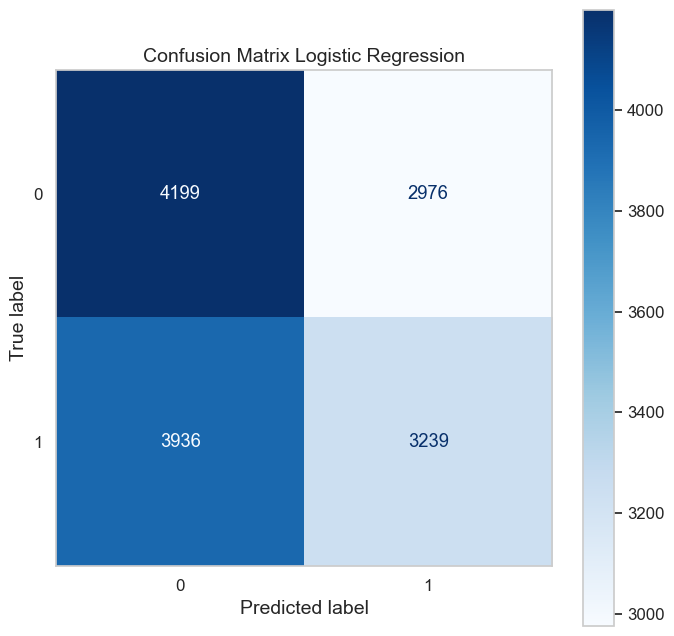

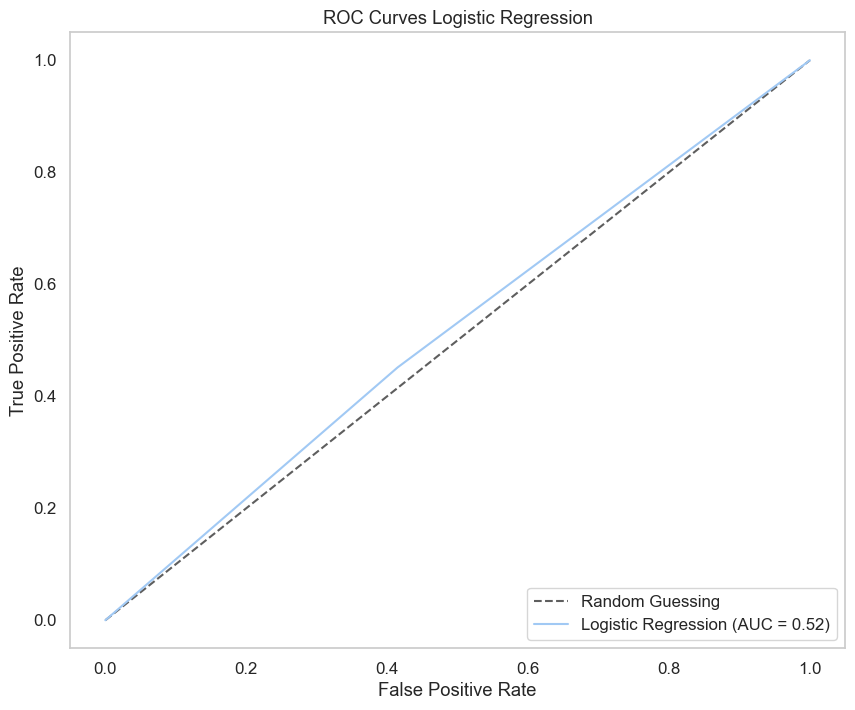

In [206]:
model_logreg = MyLogisticRegression(eta=0.01, tol=1e-4, max_iter=10000)
model_logreg.fit(X_train_pca, y_train)

y_pred_logreg = model_logreg.predict(X_test_pca)
print("Logistic Regression Custom Model:")
print(classification_report(y_test, y_pred_logreg))
print_confusion_matrix("Logistic Regression", y_pred_logreg, y_test, "PCA")

#vẽ ROC
plot_roc_curves_binary([{'name': 'Logistic Regression', 'radio': "PCA"}], y_test, y_pred_logreg)

## 4.5. Huấn luyện mô hình với tập dữ liệu giảm chiều bằng LDA

In [207]:
X_train, y_train, X_test, y_test = data_split(data, test_size=0.2)

In [208]:
lda = LinearDiscriminantAnalysis(n_components=1)

X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

### 4.5.1. KNN Classifier

              precision    recall  f1-score   support

           0       0.64      0.81      0.72      7175
           1       0.74      0.54      0.63      7175

    accuracy                           0.68     14350
   macro avg       0.69      0.68      0.67     14350
weighted avg       0.69      0.68      0.67     14350



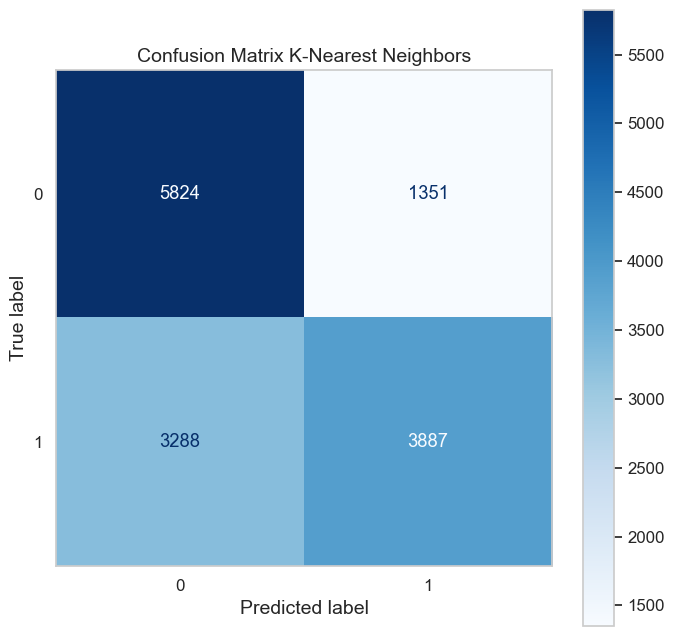

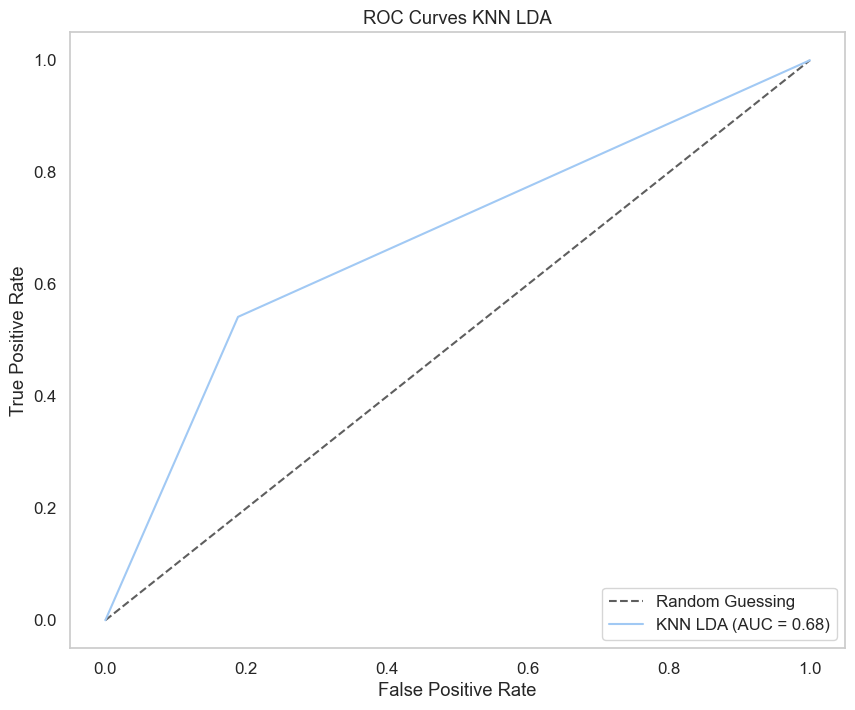

In [209]:
model_knn = MyKNNClassifier(n_neighbors=7)
model_knn.fit(X_train_lda, y_train)

y_pred_knn = model_knn.predict(X_test_lda)

print(classification_report(y_test, y_pred_knn))
print_confusion_matrix("K-Nearest Neighbors", y_pred_knn, y_test, "LDA")
#ve ROC
plot_roc_curves_binary([{'name': 'KNN LDA', 'radio': "LDA"}], y_test, y_pred_knn)

### 4.5.2. Logistic Regression

Logistic Regression Custom Model:
              precision    recall  f1-score   support

           0       0.53      0.54      0.53      7175
           1       0.53      0.52      0.52      7175

    accuracy                           0.53     14350
   macro avg       0.53      0.53      0.53     14350
weighted avg       0.53      0.53      0.53     14350



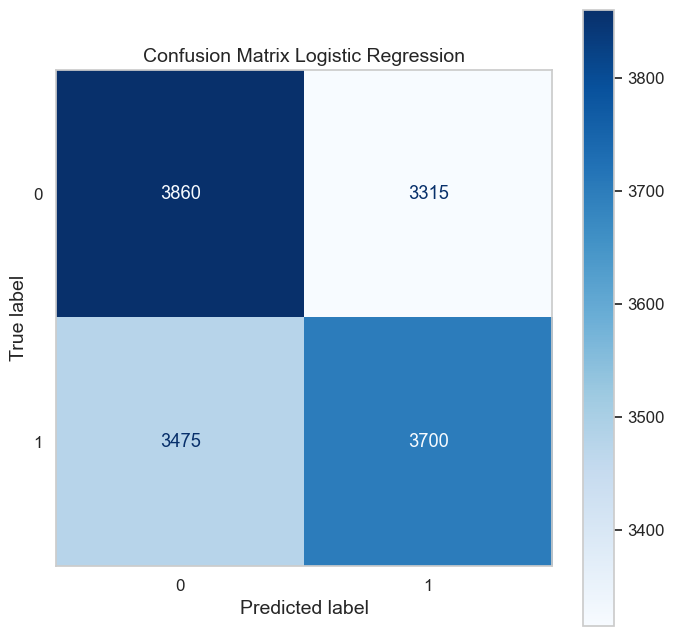

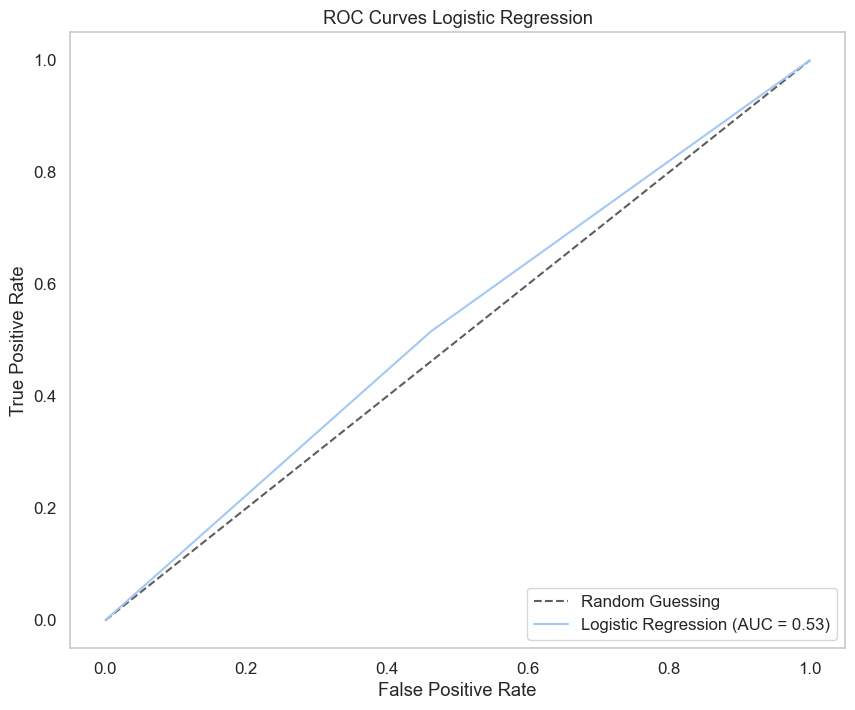

In [210]:
model_logreg = MyLogisticRegression(eta=0.01, tol=1e-4, max_iter=10000)
model_logreg.fit(X_train_lda, y_train)

y_pred_logreg = model_logreg.predict(X_test_lda)
print("Logistic Regression Custom Model:")
print(classification_report(y_test, y_pred_logreg))
print_confusion_matrix("Logistic Regression", y_pred_logreg, y_test, "LDA")

#vẽ ROC
plot_roc_curves_binary([{'name': 'Logistic Regression', 'radio': "LDA"}], y_test, y_pred_logreg)